<font size="6"><center><big><b>H-1B Visa Applications</font></center></big></b>

<font size="4"><center><big><b>Abstract</font></center></big></b>

This notebook will obtain, clean, analyse, and visualise data of H-1B Visa applications for employment-based entry into the United States from the years 2014 -- 2016. 

<font size="4"><center><big><b>TL;DR</font></center></big></b>

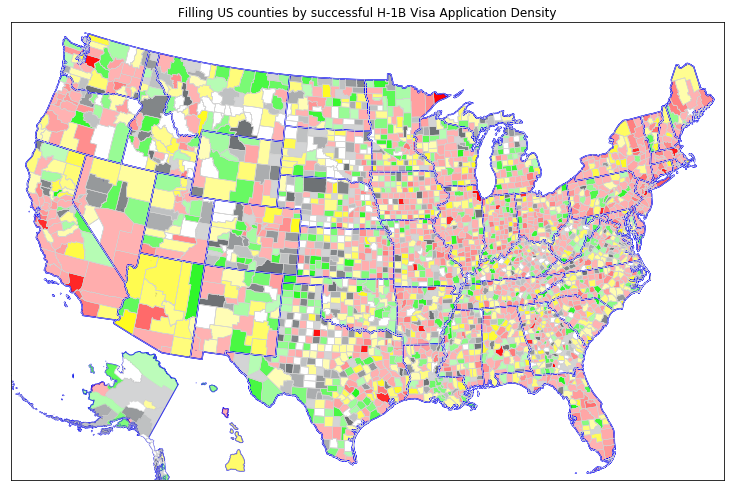

In [207]:
from IPython.display import Image
Image("trafficlights.png")

This map shows the successful H-1B applications to the US to start employment between October 2013 and March 2017, color coded according to the relative proportion each received; white is no applications, dark grey is at the 25th percentile, bright green at the 50th, bright yellow at the 75th, and bright red at the maximum, Santa Clara county in California. Shading occurs between the percentiles, so that, for example, light red is somewhere between the 75th percentile and the maximum, and similarly for the other colours. 

This map procuded after cleaning the data. We then use a Random Forest Regressor to predict salary of applicants, as well as a Random Forest Classifier to predict outcome of the application. 

<font size="4"><center><big><b>Load the necessary libraries</font></center></big></b>

In [192]:
import math as m
import pylab
import numpy as np
import pandas as pd
%matplotlib inline
import glob
import csv
import urllib.request
import difflib
import matplotlib.pyplot as plt
import matplotlib.cm
import fuzzyset
import re

#visualisation:

from matplotlib.colors import rgb2hex
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from shapely.geometry import Polygon
from descartes import PolygonPatch
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

#machine learning:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

<font size="4"><center><big><b>Load the data</font></center></big></b>

The data is available from the website of the Department of Labour (DOL in the sequel), as MS Excel Files. We can read the files directly into this notebook with the URL of the files. 

In [7]:
link14 = 'https://www.foreignlaborcert.doleta.gov/docs/py2014q4/H-1B_FY14_Q4.xlsx'
link15 = 'https://www.foreignlaborcert.doleta.gov/docs/py2015q4/H-1B_Disclosure_Data_FY15_Q4.xlsx'
link16 = 'https://www.foreignlaborcert.doleta.gov/docs/Performance_Data/Disclosure/FY15-FY16/H-1B_Disclosure_Data_FY16.xlsx'

with urllib.request.urlopen(link14) as x:
    xd14 = pd.ExcelFile(x)

with urllib.request.urlopen(link15) as x:
    xd15 = pd.ExcelFile(x)
    
with urllib.request.urlopen(link16) as x:
    xd16 = pd.ExcelFile(x)

Each Excel file has only one 'sheet':

In [8]:
all(len(t.sheet_names) == 1 for t in [xd14,xd15,xd16])

True

So we load the data into Pandas Dataframes like so:

In [5]:
df14 = xd14.parse(xd14.sheet_names[0])
df15 = xd15.parse(xd15.sheet_names[0])
df16 = xd16.parse(xd16.sheet_names[0])

<font size="4"><center><big><b>Understanding the data (the columns in particular)</font></center></big></b>

What does the data look like?

In [4]:
df14.head(10)

,LCA_CASE_NUMBER,STATUS,LCA_CASE_SUBMIT,DECISION_DATE,VISA_CLASS,LCA_CASE_EMPLOYMENT_START_DATE,LCA_CASE_EMPLOYMENT_END_DATE,LCA_CASE_EMPLOYER_NAME,LCA_CASE_EMPLOYER_ADDRESS,LCA_CASE_EMPLOYER_CITY,...,OTHER_WAGE_SOURCE_1,YR_SOURCE_PUB_1,LCA_CASE_WORKLOC2_CITY,LCA_CASE_WORKLOC2_STATE,PW_2,PW_UNIT_2,PW_SOURCE_2,OTHER_WAGE_SOURCE_2,YR_SOURCE_PUB_2,LCA_CASE_NAICS_CODE
0,I-200-09106-546545,CERTIFIED-WITHDRAWN,2013-01-18 18:05:43,2014-09-29 15:59:50,H-1B,2013-02-01,2016-02-01,TEXAS STATE UNIVERSITY-SAN MARCOS,601 UNIVERSITY DRIVE,SAN MARCOS,...,OFLC ONLINE DATA CENTER,2013.0,ST. LOUIS,MO,49566.0,Year,OES,OFLC ONLINE DATA CENTER,OFLC ONLINE DATA CENTER,611310.0
1,I-200-09162-143337,CERTIFIED,2014-03-17 11:11:45,2014-03-21 23:11:51,H-1B,2014-09-15,2017-09-15,"EYE SPECIALISTS OF INDIANA, P.C.",1901 N. MERIDIAN ST.,INDIANAPOLIS,...,OFLC ONLINE DATA CENTER,2013.0,INDIANAPOLIS,IN,64251.0,Year,Other,OFLC ONLINE DATA CENTER,OFLC ONLINE DATA CENTER,621320.0
2,I-200-09182-550211,DENIED,2014-03-14 17:05:01,2014-03-20 16:59:49,H-1B,2014-04-01,2015-04-01,"LHB, INC.",21 WEST SUPERIOR STREET,DULUTH,...,OFLIC ONLINE,2014.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,541330.0
3,I-200-09193-873099,CERTIFIED,2014-03-01 12:37:02,2014-03-06 22:03:37,H-1B,2014-08-28,2017-08-27,"WAM USA, INC.",75 BOULDERBROOK CIRCLE,LAWRENCEVILLE,...,OFLC ONLINE DATA CENTER,2014.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,333922.0
4,I-200-09197-120609,CERTIFIED-WITHDRAWN,2014-03-10 15:33:41,2014-03-17 10:52:46,H-1B,2014-09-01,2017-09-01,"DFUSE TECHNOLOGIES, INC.",20143 DESERT FOREST DRIVE,ASHBURN,...,OFLC ONLINE DATA CENTER,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,541519.0
5,I-200-09203-855998,CERTIFIED,2014-08-20 16:41:05,2014-08-26 22:01:03,H-1B,2014-08-20,2015-09-14,TAKE ENTERPRISE SERVICES INC,502 CARNEGIE CENTER,PRINCETON,...,FLC DATACENTER ONLINE WAGE LIBRARY,2014.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,541511.0
6,I-200-09205-703458,WITHDRAWN,2014-09-15 16:31:51,2014-09-15 16:38:40,H-1B,2014-09-15,2015-01-10,"TAKE SOLUTIONS, INC",502 CARNEGIE CENTER,PRINCETON,...,FLC DATA CENTER ONLINE WAGE LIBRARY,2014.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,541511.0
7,I-200-09205-927162,CERTIFIED,2014-06-26 13:21:18,2014-07-02 22:01:55,H-1B,2014-10-12,2017-10-11,"PLATTFORM ADVERTISING, INC.",15500 W. 113TH STREET,LENEXA,...,OFLC ONLINE DATA CENTER,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,541810.0
8,I-200-09208-457486,WITHDRAWN,2013-07-17 08:34:07,2014-03-18 09:56:27,H-1B,2009-08-05,2012-08-04,PROPEL CORP.,621 HILLROSE DRIVE,LOUISVILLE,...,OFLC ONLINE DATA CENTER,2009.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,541411.0
9,I-200-09211-513022,CERTIFIED-WITHDRAWN,2009-07-30 11:37:31,2014-05-13 11:11:01,H-1B,2009-09-15,2012-09-14,UT HEALTH SCIENCE CENTER AT SAN ANTONIO,7703 FLOYD CURL DR.,SAN ANTONIO,...,NaN,2009.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,611310.0


In [12]:
df16.shape[0]

647852

In [8]:
df15.isnull().sum()

CASE_NUMBER                   0
CASE_STATUS                   0
CASE_SUBMITTED                0
DECISION_DATE                 0
VISA_CLASS                    0
EMPLOYMENT_START_DATE        19
EMPLOYMENT_END_DATE          19
EMPLOYER_NAME                23
EMPLOYER_ADDRESS1            26
EMPLOYER_ADDRESS2        307943
EMPLOYER_CITY                31
EMPLOYER_STATE               43
EMPLOYER_POSTAL_CODE         38
EMPLOYER_COUNTRY             22
EMPLOYER_PROVINCE        610044
EMPLOYER_PHONE               62
EMPLOYER_PHONE_EXT       580560
AGENT_ATTORNEY_NAME      227126
AGENT_ATTORNEY_CITY      227128
AGENT_ATTORNEY_STATE     235163
JOB_TITLE                    20
SOC_CODE                     15
SOC_NAME                     16
NAIC_CODE                    20
TOTAL WORKERS                15
FULL_TIME_POSITION           13
PREVAILING_WAGE              67
PW_UNIT_OF_PAY               77
PW_WAGE_LEVEL             28708
PW_WAGE_SOURCE               74
PW_WAGE_SOURCE_YEAR          81
PW_WAGE_

Hang on a second...those columns don't seem to be the same. What are the column headings?

In [16]:
df14.keys()

Index(['LCA_CASE_NUMBER', 'STATUS', 'LCA_CASE_SUBMIT', 'DECISION_DATE',
       'VISA_CLASS', 'LCA_CASE_EMPLOYMENT_START_DATE',
       'LCA_CASE_EMPLOYMENT_END_DATE', 'LCA_CASE_EMPLOYER_NAME',
       'LCA_CASE_EMPLOYER_ADDRESS', 'LCA_CASE_EMPLOYER_CITY',
       'LCA_CASE_EMPLOYER_STATE', 'LCA_CASE_EMPLOYER_POSTAL_CODE',
       'LCA_CASE_SOC_CODE', 'LCA_CASE_SOC_NAME', 'LCA_CASE_JOB_TITLE',
       'LCA_CASE_WAGE_RATE_FROM', 'LCA_CASE_WAGE_RATE_TO',
       'LCA_CASE_WAGE_RATE_UNIT', 'FULL_TIME_POS', 'TOTAL_WORKERS',
       'LCA_CASE_WORKLOC1_CITY', 'LCA_CASE_WORKLOC1_STATE', 'PW_1',
       'PW_UNIT_1', 'PW_SOURCE_1', 'OTHER_WAGE_SOURCE_1', 'YR_SOURCE_PUB_1',
       'LCA_CASE_WORKLOC2_CITY', 'LCA_CASE_WORKLOC2_STATE', 'PW_2',
       'PW_UNIT_2', 'PW_SOURCE_2', 'OTHER_WAGE_SOURCE_2', 'YR_SOURCE_PUB_2',
       'LCA_CASE_NAICS_CODE'],
      dtype='object')

In [211]:
df15.keys()

Index(['CASE_NUMBER', 'CASE_STATUS', 'CASE_SUBMITTED', 'DECISION_DATE',
       'VISA_CLASS', 'EMPLOYMENT_START_DATE', 'EMPLOYMENT_END_DATE',
       'EMPLOYER_NAME', 'EMPLOYER_ADDRESS1', 'EMPLOYER_ADDRESS2',
       'EMPLOYER_CITY', 'EMPLOYER_STATE', 'EMPLOYER_POSTAL_CODE',
       'EMPLOYER_COUNTRY', 'EMPLOYER_PROVINCE', 'EMPLOYER_PHONE',
       'EMPLOYER_PHONE_EXT', 'AGENT_ATTORNEY_NAME', 'AGENT_ATTORNEY_CITY',
       'AGENT_ATTORNEY_STATE', 'JOB_TITLE', 'SOC_CODE', 'SOC_NAME',
       'NAIC_CODE', 'TOTAL WORKERS', 'FULL_TIME_POSITION', 'PREVAILING_WAGE',
       'PW_UNIT_OF_PAY', 'PW_WAGE_LEVEL', 'PW_WAGE_SOURCE',
       'PW_WAGE_SOURCE_YEAR', 'PW_WAGE_SOURCE_OTHER', 'WAGE_RATE_OF_PAY',
       'WAGE_UNIT_OF_PAY', 'H-1B_DEPENDENT', 'WILLFUL VIOLATOR',
       'WORKSITE_CITY', 'WORKSITE_COUNTY', 'WORKSITE_STATE',
       'WORKSITE_POSTAL_CODE'],
      dtype='object')

In [213]:
df16.keys()

Index(['CASE_NUMBER', 'CASE_STATUS', 'CASE_SUBMITTED', 'DECISION_DATE',
       'VISA_CLASS', 'EMPLOYMENT_START_DATE', 'EMPLOYMENT_END_DATE',
       'EMPLOYER_NAME', 'EMPLOYER_ADDRESS', 'EMPLOYER_CITY', 'EMPLOYER_STATE',
       'EMPLOYER_POSTAL_CODE', 'EMPLOYER_COUNTRY', 'EMPLOYER_PROVINCE',
       'EMPLOYER_PHONE', 'EMPLOYER_PHONE_EXT', 'AGENT_ATTORNEY_NAME',
       'AGENT_ATTORNEY_CITY', 'AGENT_ATTORNEY_STATE', 'JOB_TITLE', 'SOC_CODE',
       'SOC_NAME', 'NAIC_CODE', 'TOTAL_WORKERS', 'FULL_TIME_POSITION',
       'PREVAILING_WAGE', 'PW_UNIT_OF_PAY', 'PW_WAGE_SOURCE', 'PW_SOURCE_YEAR',
       'PW_SOURCE_OTHER', 'WAGE_RATE_OF_PAY_FROM', 'WAGE_RATE_OF_PAY_TO',
       'WAGE_UNIT_OF_PAY', 'H-1B_DEPENDENT', 'WILLFUL_VIOLATOR',
       'WORKSITE_CITY', 'WORKSITE_COUNTY', 'WORKSITE_STATE',
       'WORKSITE_POSTAL_CODE', 'ORIGINAL_CERT_DATE'],
      dtype='object')

So the columns are essentially the same -- they are just written slightly differently in each case. That will have to be sorted out. 

There are some important exceptions however; to see these, we'll go through and describe all of the columns we have here. 

The description of these columns is explained in the "File Structure Document" accompanying each of the data files, available [here](https://www.foreignlaborcert.doleta.gov/performancedata.cfm). Here we give a quick summary of these columns. Readers already familiar with the columns and their contents are invited to skip to the next section.

The "LCA_CASE_NUMBER"/"CASE_NUMBER" is the unique identifier of the case. This will be useful to find any duplicate entries. 

The "STATUS"/"CASE_STATUS" of the application can either be: 

'CERTIFIED' - the DOL has approved it;<br />
'DENIED' - the DOL has denied it;<br />
'WITHDRAWN' - the company applying for it withdrew the application before it being certified;<br />
'CERTIFIED-WITHDRAWN' - the company withdrew the application after it being certified

This latter class contains **BOTH** applications where the prospective employee does not start working at the company, **AS WELL AS** where the employee leaves the company. It also means that we expect to see the same "LCA_CASE_NUMBER" arising in future, to reflect the scenario where the employee leaves the company.

"LCA_CASE_SUBMIT"/"CASE_SUBMITTED" are self-explanatory. 

"DECISION_DATE" is self-explanatory. Important to note:

Data in our 2014 dataset refers to *decisions* taken between October 1st 2013 and September 30th 2014.

Data in our 2015 dataset refers to *decisions* taken between October 1st 2014 and September 30th 2015.

Data in our 2016 dataset refers to *decisions* taken between October 1st 2015 and September 30th 2016.

(In particular, the applications may have been submitted much before this.)

"VISA_CLASS" is one of:

'H-1B' - that which concerns us;<br />
'H-1B1 Chile';<br />
'H-1B1 Singapore;<br />
'E-3 Australian;<br />

There are some differences between these classes beyond merely the countries mentioned. Indeed, internet forums abound where concerned Aussies ponder the advantages of applying for H-1B over E-3 or vice-versa. Since this project is mainly concerned with H-1B, we'll ignore these other classes. 

"LCA_CASE_EMPLOYMENT_START_DATE"/"EMPLOYMENT_START_DATE" are self-explanatory. 

"LCA_CASE_EMPLOYMENT_END_DATE"/"EMPLOYMENT_END_DATE" are self-explanatory. 

Then follow fields containing details of the companies applying for these LCAs, which we need not list here. The 2015 and 2016 data even contain their phone numbers and extensions. 

"LCA_CASE_SOC_CODE"/"SOC_CODE" and "LCA_CASE_SOC_NAME"/"SOC_NAME": Jobs in the US are apparently organised by a Standard Occupational Classification (SOC) system - broad titles describing the kind of work people do - "CHIEF EXECUTIVES" and "ACCOUNTANTS" are two such that arise in the data. Each has a numerical code uniquely identifying it. 

"LCA_CASE_JOB_TITLE"/"JOB_TITLE" self explanatory.

The 2015 and 2016 data also contain information about the Attorney applying for the LCA on behalf of the company. This isn't present in the 2014 data (and will likely be quickly dropped from our considerations). 

"LCA_CASE_WAGE_RATE_FROM"/"WAGE_RATE_OF_PAY"/"WAGE_RATE_OF_PAY_FROM": This is the amount of money offered for the job per unit (see next line.)

"LCA_CASE_WAGE_RATE_UNIT"/"WAGE_UNIT_OF_PAY": Whether the money comes Daily, Hourly, Bi-weekly, Weekly, Monthly, or Yearly.

"LCA_CASE_WAGE_RATE_TO"/"WAGE_RATE_OF_PAY_TO": The maximum amount of money to be offered for the job, presumably a cap on future pay raises. This column is not available in the 2015 data, and is rather sparse in the other years anyway. As such this column is a prime candidate for the axe. 

"FULL_TIME_POS"/"FULL_TIME_POSITION": whether the job is full time or part time. 

"TOTAL_WORKERS" is the total number of foreign workers requested by the company applying for the LCA. 

"LCA_CASE_WORKLOC1_CITY"/"WORKSITE_CITY": The city where the job will be done.

"LCA_CASE_WORKLOC1_STATE"/"WORKSITE_STATE": The state where the job will be done.

"WORKSITE_COUNTY": The county where the job will be done. This is missing from the 2014 data (but can probably be looked up easily if the city and state are known). 

"PW_1"/"PREVAILING_WAGE": This is the wage or rate paid to the majority of workers in the given industry and the given location, or doing a 'similar' kind of job. 

"PW_UNIT_1"/"PW_UNIT_OF_PAY": The unit of the prevailing wage. 

Then follow some information about where this prevailing wage comes from, who calculated it etc. 

The 2014 data then has information on a possible second location for the job, together with a different prevailing wage for that location. This is not present in the 2015 or 2016 data, and seems mostly empty in the 2014 data anyway.

"LCA_CASE_NAICS_CODE"/"NAIC CODE": Industry code associated with the employer requesting permanent labor condition, as classified by the North American Industrial Classification System (NAICS).

The 2015/2016 data has three more columns not present in 2014. 

"WORKSITE_POSTAL_CODE" self-explanatory.

"H-1B_DEPENDENT": indicates whether or not the employer is "H1-B dependent", that is, they depend on H1-B workers, or have "too many" H1-B employees. See [the Wikipedia entry](https://en.wikipedia.org/wiki/H-1B-dependent_employer) for more information. 

"WILLFUL_VIOLATOR": Indicates whether or not the employer is a "willful violator", meaning they have violated conditions or agreements of employing foreign workers, or have been found to have misrepresented facts. Such companies have to provide additional documents when applying for LCAs, and one is tempted to claim that it is harder for such companies to obtain Certified LCAs. (We could look into this.)

Finally, the 2016 data has one column not present in the other two: "ORIGINAL_CERT_DATE", indicating, in the case of a WITHDRAWN application, when the LCA was originally certified. This column is mostly empty however. 

<font size="4"><center><big><b>Killing undesired columns, and cleaning the remaining column headings</font></center></big></b>

These three datasets have lots of information not of interest for our ensuing analysis. We start by identifying the columns we care about and want to keep, and creating a dictionary for the various ways these appear in our three data sets. This is necessary to standardise the column names. 

We first need to create a dictionary between 'clean' and 'dirty' names. This is most easily done by inspection, seeing which column heading corresponds with which other, like so:

In [15]:
CleanCols = {
 'CASE_NUMBER': ['CASE_NUMBER', 'LCA_CASE_NUMBER'],
 'CASE_STATUS': ['CASE_STATUS', 'STATUS'],
 'CASE_SUBMITTED': ['CASE_SUBMITTED'],
 'DECISION_DATE': ['DECISION_DATE'],
 'EMPLOYER_NAME': ['EMPLOYER_NAME', 'LCA_CASE_EMPLOYER_NAME'],
 'EMPLOYMENT_END_DATE': ['EMPLOYMENT_END_DATE','LCA_CASE_EMPLOYMENT_END_DATE'],
 'EMPLOYMENT_START_DATE': ['EMPLOYMENT_START_DATE','LCA_CASE_EMPLOYMENT_START_DATE'],
 'FULL_TIME_POSITION': ['FULL_TIME_POSITION', 'FULL_TIME_POS'],
 'H-1B_DEPENDENT': ['H-1B_DEPENDENT'],
 'PREVAILING_WAGE': ['PREVAILING_WAGE'],
 'PW_UNIT_OF_PAY': ['PW_UNIT_OF_PAY', 'WAGE_UNIT_OF_PAY'],
 'SOC_CODE': ['SOC_CODE', 'LCA_CASE_SOC_CODE'],
 'SOC_NAME': ['SOC_NAME', 'LCA_CASE_SOC_NAME'],
 'TOTAL_WORKERS': ['TOTAL_WORKERS', 'TOTAL WORKERS'],
 'VISA_CLASS': ['VISA_CLASS'],
 'WAGE_RATE_OF_PAY_FROM': ['WAGE_RATE_OF_PAY_FROM','WAGE_RATE_OF_PAY','LCA_CASE_WAGE_RATE_FROM'],
 'WAGE_UNIT_OF_PAY': ['WAGE_UNIT_OF_PAY', 'PW_UNIT_OF_PAY'],
 'WILLFUL_VIOLATOR': ['WILLFUL_VIOLATOR', 'WILLFUL VIOLATOR'],
 'WORKSITE_CITY': ['WORKSITE_CITY', 'WORKSITE_COUNTY'],
 'WORKSITE_COUNTY': ['WORKSITE_COUNTY', 'WORKSITE_CITY'],
 'WORKSITE_STATE': ['WORKSITE_STATE', 'WORKSITE_POSTAL_CODE']
}

Needless to say, this approach - although simple - is rather error-prone; it's easy to make a typo or other error if one were to type all of this out. It's also not a great approach in general, where there might be lots more columns. An alternative approach is to use the library 'difflib' to search for close matches, and then clean up what's left. Although this won't give the dictionary in one go, and the output will have to be checked, it does significantly reduce the amount of manual input required.

We first choose standard names to serve as the keys of the dictionary. Since the 2016 column headings are the 'cleanest', we'll choose the desired columns from there.

In [10]:
StandardNames = ['CASE_NUMBER', 'CASE_STATUS','CASE_SUBMITTED','DECISION_DATE','VISA_CLASS','EMPLOYMENT_START_DATE','EMPLOYMENT_END_DATE','EMPLOYER_NAME','SOC_CODE','SOC_NAME','TOTAL_WORKERS','PREVAILING_WAGE','PW_UNIT_OF_PAY','WAGE_RATE_OF_PAY_FROM','WAGE_UNIT_OF_PAY','WORKSITE_CITY','WORKSITE_COUNTY', 'WORKSITE_STATE']
assert all(f in df16.keys() for f in StandardNames),"Looks like you made a mistake tying (sic!) there!"

A sanity check has been built in here; if there's any error in typing here, an error will be raised. 

So now we'll build the dictionary using the fuzzy text search function difflib.get_close_matches. Before running it, we will run a preliminary cleaning on the names; namely, if the column begins with 'LCA_CASE_', that is then replaced with a "7" at the end of the string. This is merely to improve the matches when running "get_close_matches". (The "7" is to keep track of where this replacement has occured, since it will have to be replaced; that's what these two functions Rep7 and RepLCA are doing.)

In [11]:
DirtyNames = list(set().union(df14.keys(),df15.keys()))
AllNames = list(set().union(df14.keys(),df15.keys(),df16.keys()))

def Rep7(input):
    if 'LCA_CASE_' in input:
        output = input.replace('LCA_CASE_','')
        output = output + '7'
        return output
    else:
        return input
                  
def RepLCA(input):
    if input[-1] == '7':
        output = input[:-1]
        output = 'LCA_CASE_' + output
        return output
    else:
        return input
                  
LessDirtyNames = [Rep7(f) for f in DirtyNames]
                  
CleanCols = {}
for f in StandardNames:
    CloseMatches = difflib.get_close_matches(f,LessDirtyNames,n=2,cutoff=0.65)
    CloseMatches = [RepLCA(f) for f in CloseMatches]
    if f in CloseMatches:
        CleanCols[f] = CloseMatches
    else:
        CleanCols[f] = [f] + CloseMatches

CleanCols

{'CASE_NUMBER': ['CASE_NUMBER', 'LCA_CASE_NUMBER'],
 'CASE_STATUS': ['CASE_STATUS', 'STATUS'],
 'CASE_SUBMITTED': ['CASE_SUBMITTED'],
 'DECISION_DATE': ['DECISION_DATE'],
 'EMPLOYMENT_END_DATE': ['EMPLOYMENT_END_DATE',
  'LCA_CASE_EMPLOYMENT_END_DATE'],
 'EMPLOYMENT_START_DATE': ['EMPLOYMENT_START_DATE',
  'LCA_CASE_EMPLOYMENT_START_DATE'],
 'PREVAILING_WAGE': ['PREVAILING_WAGE'],
 'PW_UNIT_OF_PAY': ['PW_UNIT_OF_PAY', 'WAGE_UNIT_OF_PAY'],
 'SOC_CODE': ['SOC_CODE', 'LCA_CASE_SOC_CODE'],
 'SOC_NAME': ['SOC_NAME', 'LCA_CASE_SOC_NAME'],
 'TOTAL_WORKERS': ['TOTAL_WORKERS', 'TOTAL WORKERS'],
 'VISA_CLASS': ['VISA_CLASS'],
 'WAGE_RATE_OF_PAY_FROM': ['WAGE_RATE_OF_PAY_FROM',
  'WAGE_RATE_OF_PAY',
  'LCA_CASE_WAGE_RATE_FROM'],
 'WAGE_UNIT_OF_PAY': ['WAGE_UNIT_OF_PAY', 'PW_UNIT_OF_PAY'],
 'WORKSITE_CITY': ['WORKSITE_CITY', 'WORKSITE_COUNTY'],
 'WORKSITE_COUNTY': ['WORKSITE_COUNTY', 'WORKSITE_CITY'],
 'WORKSITE_STATE': ['WORKSITE_STATE', 'WORKSITE_POSTAL_CODE']}

We now have to verify that everything is as it should be. Of course, it isn't, and so we fix the remaining issues manually.

In [12]:
CleanCols['CASE_SUBMITTED'] = ['CASE_SUBMITTED','LCA_CASE_SUBMIT']
CleanCols['PREVAILING_WAGE'] = ['PREVAILING_WAGE','PW_1']
CleanCols['PW_UNIT_OF_PAY'] = ['PW_UNIT_OF_PAY','PW_UNIT_1']
CleanCols['WAGE_UNIT_OF_PAY'] = ['WAGE_UNIT_OF_PAY','LCA_CASE_WAGE_RATE_UNIT']
CleanCols['WORKSITE_CITY'] = ['WORKSITE_CITY','LCA_CASE_WORKLOC1_CITY']
CleanCols['WORKSITE_COUNTY'] = ['WORKSITE_COUNTY']
CleanCols['WORKSITE_STATE'] = ['WORKSITE_STATE','LCA_CASE_WORKLOC1_STATE']

As ever, such manual entry demands sanity check:

In [13]:
assert all(f in df16.keys() for f in CleanCols.keys()), "Mistake in typing keys"
assert all(f in AllNames for g in CleanCols.values() for f in g),"Mistake in tying dictionary values"

Finally, having this dictionary in hand allows us to rename the columns in our dataframes to the standard 2016 names. 

In [14]:
def RenameCols(df,desired):
    df.rename(columns={el:k for k,v in desired.items() for el in v}, inplace=True)
    return df[[k for k in desired.keys() if k in df.columns]]

df14 = RenameCols(df14,CleanCols)
df15 = RenameCols(df15,CleanCols)
df16 = RenameCols(df16,CleanCols)

Note that this has removed all unwanted columns from the dataframe. The columns in the 2015 and 2016 dataframes are now identical; the 2014 data does not have the following columns (because it didn't originally have them):

* WORKSITE_COUNTY
* H-1B_DEPENDENT
* WILLFUL_VIOLATOR

<font size="4"><center><big><b>Sanity checking and cleaning the data</font></center></big></b>

Since we are only concerned with H-1B applications, we first remove the data where the VISA_CLASS is not H-1B.

In [14]:
df14['VISA_CLASS'].value_counts(dropna=False)

H-1B               508676
E-3 Australian       9446
H-1B1 Singapore       825
H-1B1 Chile           557
Name: VISA_CLASS, dtype: int64

In [15]:
df15['VISA_CLASS'].value_counts(dropna=False)

H-1B               605803
E-3 Australian      11185
H-1B1 Singapore      1074
H-1B1 Chile           742
Name: VISA_CLASS, dtype: int64

In [16]:
df16['VISA_CLASS'].value_counts(dropna=False)

H-1B                          633943
E-3 Australian                 11934
H-1B1 Singapore                 1099
H-1B1 Chile                      875
Select Visa Classification         1
Name: VISA_CLASS, dtype: int64

Observe that in the 2016 data, there is one 'missing value', written as 'Select Visa Classification'. We'll take the simple approach and just ignore it, rather than try to impute its value, as its only one data point out of 633,943. 

In [15]:
#DataTables = [df14,df15,df16]
#DataTables = [dat[dat.VISA_CLASS == 'H-1B'] for dat in DataTables]
df14,df15,df16 = [dat[dat.VISA_CLASS == 'H-1B'] for dat in [df14,df15,df16]]
df14,df15,df16 = [dat.reset_index(drop=True) for dat in [df14,df15,df16]]

Before dealing with any missing values, let's clean the data we have, starting with *CASE_NUMBER*

In [49]:
rex = re.compile("^(I-)[0-9]{3}[-][0-9]{5}[-][0-9]{6}$")
assert all(rex.match(f) for dat in [df14,df15,df16] for f in dat.CASE_NUMBER)

Let's check the next column, CASE_STATUS

In [20]:
df14.CASE_STATUS.value_counts(dropna=False)

CERTIFIED              446416
CERTIFIED-WITHDRAWN     35742
WITHDRAWN               15726
DENIED                  10790
REJECTED                    2
Name: CASE_STATUS, dtype: int64

In [220]:
df15.CASE_STATUS.value_counts(dropna=False)

CERTIFIED              536693
CERTIFIED-WITHDRAWN     40368
WITHDRAWN               19039
DENIED                   9703
Name: CASE_STATUS, dtype: int64

In [221]:
df16.CASE_STATUS.value_counts(dropna=False)

CERTIFIED              558014
CERTIFIED-WITHDRAWN     46294
WITHDRAWN               21432
DENIED                   8203
Name: CASE_STATUS, dtype: int64

Aha, so the 2014 data contains two instances of the value "REJECTED", which probably should be "DENIED". Let's change that; otherwise it's fine. 

In [17]:
df14.loc[df14['CASE_STATUS'] == 'REJECTED','CASE_STATUS'] = 'DENIED'

Let's check that it worked:

In [22]:
df14.CASE_STATUS.value_counts(dropna=False)

CERTIFIED              446416
CERTIFIED-WITHDRAWN     35742
WITHDRAWN               15726
DENIED                  10792
Name: CASE_STATUS, dtype: int64

We're now going to clean up the four date columns, namely, 

* CASE_SUBMITTED
* DECISION_DATE
* EMPLOYMENT_START_DATE
* EMPLOYMENT_END_DATE

It makes for easier code reading if these are all done together. There are two issues, one more serious than the other. 

The first is that, in the 2015 data, the EMPLOYMENT date columns are written differently than all the other date columns. Not only are they presented in a different order, but they are strings, as opposed to 'Timestamps', and we prefer the latter, as we can use the library datetime or ther functions on them. 

In [304]:
df15.head(3)

,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,SOC_CODE,SOC_NAME,...,FULL_TIME_POSITION,PREVAILING_WAGE,PW_UNIT_OF_PAY,WAGE_RATE_OF_PAY_FROM,WAGE_UNIT_OF_PAY,H-1B_DEPENDENT,WILLFUL_VIOLATOR,WORKSITE_CITY,WORKSITE_COUNTY,WORKSITE_STATE
0,I-200-09121-701936,WITHDRAWN,2015-02-05,2015-02-05,H-1B,2015-02-09,2015-02-28,"MEDTRONIC, INC.",17-2141.00,MECHANICAL ENGINEERS,...,Y,19000.0,Year,20000 -,Year,N,N,EDEN PRAIRIE,STERNS,CA
1,I-200-09146-796321,CERTIFIED,2014-12-12,2014-12-18,H-1B,2015-01-05,2018-01-04,UNIVERSITY OF OKLAHOMA,25-1032,"ENGINEERING TEACHERS, POSTSECONDARY",...,Y,42860.0,Year,85000.00 -,Year,N,N,NORMAN,CLEVELAND,OK
2,I-200-09180-329758,WITHDRAWN,2013-01-03,2014-12-15,H-1B,2013-01-07,2016-01-06,NOKIA INC.,15-1799,"COMPUTER OCCUPATIONS, ALL OTHER*",...,Y,73965.0,Year,94000 -,Year,N,N,SAN DIEGO,SAN DIEGO,CA


The second issue is that, in the 2014 data, some of these date columns contain the time as well. This isn't a serious issue, but since we don't really care about the hour/minute/second these decisions are made, it would be nice to strip that, and have all of the dates looking the same. 

In [305]:
df14.head(1)

,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,SOC_CODE,SOC_NAME,TOTAL_WORKERS,FULL_TIME_POSITION,PREVAILING_WAGE,PW_UNIT_OF_PAY,WAGE_RATE_OF_PAY_FROM,WAGE_UNIT_OF_PAY,WORKSITE_CITY,WORKSITE_STATE
0,I-200-09106-546545,CERTIFIED-WITHDRAWN,2013-01-18 18:05:43,2014-09-29 15:59:50,H-1B,2013-02-01,2016-02-01,TEXAS STATE UNIVERSITY-SAN MARCOS,19-1029,"Biological Scientists, All Other",1.0,Y,43118.0,Year,50000.0,Year,SAN MARCOS,TX


We'll deal with that 2015 issue first, starting with "EMPLOYMENT_START_DATE". We'll first create a new column, 'EMPLOYMENT_START_CLEAN", which will take the "EMPLOYMENT_START_DATE", and convert it to datetime format. 

The reader may be wondering why we have opted to create a new column rather than merely replace the existing one. The reason is due to hindsight; we did tried this first, but an error was raised, due to a nonsense date (e.g. 45th of October). Rather than just live with adding errors, we decided to actually see what these nonsense dates were. The following code will create the new column, and compare the new column with the old when the new column has errors. 

In [18]:
df15['EMPLOYMENT_START_CLEAN'] = df15['EMPLOYMENT_START_DATE'].apply(lambda x: pd.to_datetime(x,errors='coerce'))
df1 = df15[df15['EMPLOYMENT_START_CLEAN'].isnull()]
df1[['EMPLOYMENT_START_DATE','EMPLOYMENT_START_CLEAN']]

,EMPLOYMENT_START_DATE,EMPLOYMENT_START_CLEAN
482,NaN,NaT
8925,NaN,NaT
13805,NaN,NaT
16380,NaN,NaT
17620,NaN,NaT
19645,NaN,NaT
19662,NaN,NaT
22741,NaN,NaT
25533,NaN,NaT
51430,NaN,NaT


Aha, so these two dates - 31st September - should probably be 30th September. We'll change that in the "Clean" column, replace EMPLOYMENT_START_DATE with EMPLOYMENT_CLEAN, and then drop EMPLOYMENT_CLEAN

In [19]:
df15.set_value(416756,'EMPLOYMENT_START_CLEAN',pd.to_datetime('09/30/2015'))
df15.set_value(430635,'EMPLOYMENT_START_CLEAN',pd.to_datetime('09/30/2015'))
df15['EMPLOYMENT_START_DATE'] = df15['EMPLOYMENT_START_CLEAN']
df15.drop('EMPLOYMENT_START_CLEAN', axis=1, inplace=True)

We now do the same thing for EMPLOYMENT_END_DATE

In [20]:
df15['EMPLOYMENT_END_CLEAN'] = df15['EMPLOYMENT_END_DATE'].apply(lambda x: pd.to_datetime(x,errors='coerce'))
df1 = df15[df15['EMPLOYMENT_END_CLEAN'].isnull()]
df1[['EMPLOYMENT_END_DATE','EMPLOYMENT_END_CLEAN']]

,EMPLOYMENT_END_DATE,EMPLOYMENT_END_CLEAN
482,NaN,NaT
8925,NaN,NaT
13805,NaN,NaT
16380,NaN,NaT
17620,NaN,NaT
19645,NaN,NaT
19662,NaN,NaT
22741,NaN,NaT
25533,NaN,NaT
51430,NaN,NaT


Good, so no erroneous dates, so we can go ahead and replace EMPLOYMENT_END_DATE with EMPLOYMENT_END_CLEAN, and drop the latter:

In [21]:
df15['EMPLOYMENT_END_DATE'] = df15['EMPLOYMENT_END_CLEAN']
df15.drop('EMPLOYMENT_END_CLEAN', axis=1, inplace=True)

In [301]:
df15.head(3)

,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,SOC_CODE,SOC_NAME,...,FULL_TIME_POSITION,PREVAILING_WAGE,PW_UNIT_OF_PAY,WAGE_RATE_OF_PAY_FROM,WAGE_UNIT_OF_PAY,H-1B_DEPENDENT,WILLFUL_VIOLATOR,WORKSITE_CITY,WORKSITE_COUNTY,WORKSITE_STATE
0,I-200-09121-701936,WITHDRAWN,2015-02-05,2015-02-05,H-1B,2015-02-09,2015-02-28,"MEDTRONIC, INC.",17-2141.00,MECHANICAL ENGINEERS,...,Y,19000.0,Year,20000 -,Year,N,N,EDEN PRAIRIE,STERNS,CA
1,I-200-09146-796321,CERTIFIED,2014-12-12,2014-12-18,H-1B,2015-01-05,2018-01-04,UNIVERSITY OF OKLAHOMA,25-1032,"ENGINEERING TEACHERS, POSTSECONDARY",...,Y,42860.0,Year,85000.00 -,Year,N,N,NORMAN,CLEVELAND,OK
2,I-200-09180-329758,WITHDRAWN,2013-01-03,2014-12-15,H-1B,2013-01-07,2016-01-06,NOKIA INC.,15-1799,"COMPUTER OCCUPATIONS, ALL OTHER*",...,Y,73965.0,Year,94000 -,Year,N,N,SAN DIEGO,SAN DIEGO,CA


So now all 12 date columns are of the same format; so we'll go ahead and strip the time from all. (Even in the columns where the time is not visible, it is actually still there as 00:00:00.)

In [22]:
for Col in ['CASE_SUBMITTED','DECISION_DATE','EMPLOYMENT_START_DATE','EMPLOYMENT_END_DATE']:
    df14[Col] = df14[Col].apply(lambda x:x.date())
    df15[Col] = df15[Col].apply(lambda x:x.date())
    df16[Col] = df16[Col].apply(lambda x:x.date())

As an added sanity check, we can check that the EMPLOYMENT_START_DATE always precedes the EMPLOYMENT_END_DATE:

In [328]:
assert all(dat.EMPLOYMENT_START_DATE[i] <= dat.EMPLOYMENT_END_DATE[i] or pd.isnull(dat.EMPLOYMENT_END_DATE[i]) or pd.isnull(dat.EMPLOYMENT_START_DATE[i]) for dat in [df14] for i in range(len(df14)))

AssertionError: 

Oh dear, that means that somewhere, EMPLOYMENT_END_DATE is before EMPLOYMENT_START_DATE. Let's investigate:

In [23]:
df14[df14.EMPLOYMENT_START_DATE > df14.EMPLOYMENT_END_DATE][['CASE_STATUS','EMPLOYMENT_START_DATE','EMPLOYMENT_END_DATE']]


,CASE_STATUS,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE
170066,DENIED,2014-09-22,2014-09-21
401955,DENIED,2014-09-19,2014-03-23
425424,WITHDRAWN,2014-10-01,2014-03-15
427368,DENIED,2014-10-01,2014-09-30


We considered 'fixing' this by swapping the START and END dates, but then realised that this mistake probably affected the CASE_STATUS; it's not surprising that these applications were denied or withdrawn if they had these glaring errors. Thus, we decided that this error is significant, and should be left as it is. 

<font size="4"><center><big><b>Cleaning up SOC-CODE and SOC-NAME</font></center></big></b>

These columns are quite significant for predicting salary, which we'll do later, and are quite messy. The SOC-CODE is supposed to be of the form '00-0000' where the zeros represent integers; but often the dash is missing, or is replaced with /, or many other things not worth documenting here. Moreover, the SOC-NAME associated with each SOC-CODe is often misspelt, or numerous variations exist. Let's first see the NaNs in these two columns.

In [204]:
[dat[COL].isnull().sum() for dat in [df14,df15,df16] for COL in ['SOC_CODE','SOC_NAME']]

[49, 4271, 15, 16, 8, 8]

The following code will simultaneously clean both of these columns. The idea is as follows: first, a dictionary of valid SOC-CODES, together with an instance of its corresponding SOC-NAME, is generated. This serves as the "canonical" SOC-CODE and SOC-NAME; after cleaning, *every* value in these columns will be in this dictionary, and in that sense these columns will have been standardised. 

Having created this dictionary, we clean the SOC-CODE as follows: going through each row, if the SOC-CODE (let's call it $x$) is in the keys of the dictionary, then that's fine, move onto the next row, but if not, then things get interesting: if $x$ is not null, then look for $x$ in the keys via a fuzzy string search; if a match is found, then replace $x$ with the match and move on; if no match is found, then look at the SOC-NAME; if that's in the dictionary, then look up the corresponding code; if that's not in the dictionary, then try a fuzzy search again, and if a match is found, return the corresponding code. If no match is found for the SOC-NAME, then all hope is lost, and return NaN. Cleaning the SOC-NAME is analogous. 

More annotations will be present near the code.

In [ ]:
#this preclean function improves the accuracy of the Fuzzy search and speed of the code.
#We noticed that many of the SOC-CODES ended with .xx, for x some digit. This sorts that 
#out.

def PreClean(x):
    if pd.notnull(x):
        x = str(x)
        if len(x) > 3 and x[-3] == '.':
            return x[:-3]
        else:
            return x
    else:
        return x

df14['SOC_CODE'] = df14['SOC_CODE'].apply(PreClean)
df15['SOC_CODE'] = df15['SOC_CODE'].apply(PreClean)
df16['SOC_CODE'] = df16['SOC_CODE'].apply(PreClean)

# here we begin to create the dictionary

df14s,df15s,df16s = [dat[['SOC_CODE','SOC_NAME']] for dat in [df14,df15,df16]]
df14s,df15s,df16s = [dat.drop_duplicates() for dat in [df14s,df15s,df16s]]

PreDict = pd.concat([df14s,df15s,df16s])
PreDict = PreDict.drop_duplicates()
crex = re.compile("^[0-9]{2}[-][0-9]{4}$") #this is the form the SOC-CODE must take

#the following will only select the valid SOC-CODES

def CleanPreDict(x):
    if pd.isnull(x):
        return x
    else:
        y = str(x)
        if crex.match(y) is not None:
            return y
        else:
            return np.nan
        
PreDict['SOC_CODE'] = PreDict['SOC_CODE'].apply(CleanPreDict)

PreDict = PreDict.dropna(subset=['SOC_CODE'])

#Even though we have we dropped duplicates in PreDict, there might be several variations
#of Names associated to the codes. The following just selects the first (non-null) instance 
#of the name.

def ReturnFirst(input):
    x=input.tolist()
    
    for i in range(len(x)):
        if pd.notnull(x[i]):
            return x[i]
    return np.nan

LookUpTable = PreDict.groupby('SOC_CODE')['SOC_NAME'].agg(ReturnFirst).to_dict()
LookUpTable = {k: v.capitalize() for k, v in LookUpTable.items() if pd.notnull(v)}

#The inverse dictionary is also required. 

ReverseLookUp = {i[1]:i[0] for i in LookUpTable.items()}

#The following sets are precomputed to save time in the fuzzy text search. 


LookUpTableValues = LookUpTable.values()
LookUpTableSet = set(LookUpTableValues)
LookUpTableValuesFast = fuzzyset.FuzzySet()
TheKeys = set(LookUpTable.keys())
TheKeysFast = fuzzyset.FuzzySet()

for k in LookUpTableSet:
    LookUpTableValuesFast.add(k)
    
for k in TheKeys:
    TheKeysFast.add(k)

#Here's the meat of the code, sketched above. 
    
def CleaningSocName(row):
    x = row['SOC_NAME']
    if x in LookUpTableSet:
        return x
    else:
        if pd.notnull(x):
            Options = LookUpTableValuesFast.get(x)
            if Options is not None:
                return Options[0][1]
            else:
                y = row['SOC_CODE']
                if pd.isnull(y):
                    return np.nan
                else:
                    if y in TheKeys:
                        return LookUpTable[y]
                    else:
                        Options = TheKeysFast.get(y)
                        if Options is not None:
                            return LookUpTable[Options[0][1]]
                        else:
                            return np.nan
        else:
            y = row['SOC_CODE']
            if pd.isnull(y):
                return np.nan
            else:
                if y in TheKeys:
                    return LookUpTable[y]
                else:
                    Options = TheKeysFast.get(y)
                    if Options is not None:
                        return LookUpTable[Options[0][1]]
                    else:
                        return np.nan
            
def CleaningSocCode(row):
    x = row['SOC_CODE']
    if x in TheKeys:
        return x
    else:
        if pd.notnull(x):
            Options = TheKeysFast.get(x)
            if Options is not None:
                return Options[0][1]
            else:
                y = row['SOC_NAME']
                if pd.isnull(y):
                    return np.nan
                else:
                    if y in LookUpTableSet:
                        return ReverseLookUp[y]
                    else:
                        Options = LookUpTableValuesFast.get(y)
                        if Options is not None:
                            return ReverseLookUp[Options[0][1]]
                        else:
                            return np.nan
        else:
            y = row['SOC_NAME']
            if pd.isnull(y):
                return np.nan
            else:
                if y in LookUpTableSet:
                    return ReverseLookUp[y]
                else:
                    Options = LookUpTableValuesFast.get(y)
                    if Options is not None:
                        return ReverseLookUp[Options[0][1]]
                    else:
                        return np.nan
                    
                
df14['SOC_NAME'] = df14.apply(CleaningSocName,axis=1)
df15['SOC_NAME'] = df15.apply(CleaningSocName,axis=1)
df16['SOC_NAME'] = df16.apply(CleaningSocName,axis=1)

df14['SOC_CODE'] = df14.apply(CleaningSocCode,axis=1)
df15['SOC_CODE'] = df15.apply(CleaningSocCode,axis=1)
df16['SOC_CODE'] = df16.apply(CleaningSocCode,axis=1)

Let's see how many NaNs we have now.

In [194]:
[dat[COL].isnull().sum() for dat in [df14,df15,df16] for COL in ['SOC_CODE','SOC_NAME']]

[40, 40, 16, 16, 6, 6]

Not bad at all! Let's just check all the SOC-CODES adhere to the required format '00-0000':

In [195]:
#Sanity check

all(crex.match(f) for dat in [df14,df15,df16] for f in dat.SOC_CODE if pd.notnull(f))

True

<font size="4"><center><big><b>Total Workers</font></center></big></b>

The values in TOTAL_WORKERS ought to be integers, as they are in the case of the 2016 data:

In [41]:
df16.TOTAL_WORKERS.dtype

dtype('int64')

However, because there are missing values in this column in the 2014 and 2015 data, Pandas considers the whole column as dtype float64.

In [42]:
[dat.TOTAL_WORKERS.dtype for dat in [df14,df15]]

[dtype('float64'), dtype('float64')]

We simply want to sanity check these columns, namely, that the values are either NaN, or actually an integer. 

In [43]:
assert all(x.is_integer() for dat in [df14,df15] for x in dat['TOTAL_WORKERS'] if pd.notnull(x))  

Here's a nice little Easter Egg in the 2014 data: CalTech applied for 2,013 Materials Scientists to start work on 1st October 2014! Not surprisingly, this application was denied. (Of course, that's most likely an error in the TOTAL_WORKERS column...)

In [44]:
df14[df14['TOTAL_WORKERS'] == 2013]

,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,SOC_CODE,SOC_NAME,TOTAL_WORKERS,FULL_TIME_POSITION,PREVAILING_WAGE,PW_UNIT_OF_PAY,WAGE_RATE_OF_PAY_FROM,WAGE_UNIT_OF_PAY,WORKSITE_CITY,WORKSITE_STATE
424826,I-200-14181-605184,DENIED,2014-06-30,2014-07-03,H-1B,2014-10-01,2017-09-30,CALIFORNIA INSTITUTE OF TECHNOLOGY,19-2032,Materials Scientists,2013.0,Y,48672.0,Year,81600.0,Year,PASADENA,CA


<font size="4"><center><big><b>The four wages columns</font></center></big></b>

We first check that PREVAILING_WAGE and WAGE_RATE_OF_PAY_FROM are floats:

In [69]:
all(dat[COL].dtype == 'float64' for dat in [df14,df15,df16] for COL in ['PREVAILING_WAGE','WAGE_RATE_OF_PAY_FROM'])

False

Oh, what's wrong? Aha, it's the 2015 WAGE_RATE_OF_PAY_COLUMN:

In [88]:
df15.head(5)['WAGE_RATE_OF_PAY_FROM']

0           20000 -
1        85000.00 -
2           94000 -
3     66000 - 70000
4    97000 - 143300
Name: WAGE_RATE_OF_PAY_FROM, dtype: object

The geniuses at the DOL in 2015 decided to put in a *range* of salaries here, just to make everyone's lives harder. We're going to want to sort this out; since mostly there's only a number before the dash (i.e. a starting salary), we'll cut the string at the '-', and convert the first part to a float. We had first better check that every entry contains a '-':

In [86]:
len(df15[~df15['WAGE_RATE_OF_PAY_FROM'].str.contains('-')]) == 0

True

Phew! OK, so let's go!

In [99]:
BadGuys=[]
for x in df15['WAGE_RATE_OF_PAY_FROM']:
    y = x.partition('-')[0]
    try:
        float(y)
    except ValueError:
        BadGuys.append(x)
        
BadGuys

['-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-']

So, if it can't convert the first part of the string to a float, then we have no information here, so we will return None, and get a NaN:

In [53]:
df15['WAGE_RATE_OF_PAY_FROM'] = df15['WAGE_RATE_OF_PAY_FROM'].apply(lambda x : float(x.partition('-')[0]) if x != '-' else np.nan)



Let's just observe our cleaned column:

In [54]:
df15.head(10)['WAGE_RATE_OF_PAY_FROM']

0     20000.00
1     85000.00
2     94000.00
3     66000.00
4     97000.00
5     20000.00
6    155000.00
7     64100.00
8    125000.00
9        22.46
Name: WAGE_RATE_OF_PAY_FROM, dtype: float64

Nice! So finally let's check that the columns are floats.

In [103]:
all(dat[COL].dtype == 'float64' for dat in [df14,df15,df16] for COL in ['PREVAILING_WAGE','WAGE_RATE_OF_PAY_FROM'])

True

We finally check that the two columns PW_UNIT_OF_PAY and WAGE_UNIT_OF_PAY take only the values 'Year', 'Hour', 'Month', 'Week', 'Bi-Weekly' or NaN across all three years:

In [112]:
all(x in ['Year','Hour','Month','Week','Bi-Weekly'] for Dat in [df14,df15,df16] for COL in ['PW_UNIT_OF_PAY','WAGE_UNIT_OF_PAY'] for x in Dat[COL] if pd.notnull(x))

True

<font size="4"><center><big><b>Check City, County, State</font></center></big></b>

Recall that the 2014 data is missing a WORKSITE_COUNTY column, so there are 8 columns of City, County, State. For our later purposes, only the COUNTY and STATE columns will be of use, so we'll focus on cleaning those.

We first need to get information about cities, counties and states in the US as a datatable. We found one on GitHub, and used it to create a 'Master Key' of all cities in the US, and which county they're in. This MasterKey constructed below is a dictionary with keys the states, and values a 4-tuple, the main component of which is *another* dictionary of the cities in that state (the keys) and which county they're in (the values). We decided to split the big list into (essentially) 50 smaller lists like this to speed up the fuzzy searching necessary to fill in counties from city or state data. After all, if you know the city and the state but not the county (which is the case in the 2014 data), then why search for the city in the big list of cities and not the smaller list of cities in the state you know? The other values of that 4-tuple are precomputed lists of the counties and cities, to speed-up fuzzy searching. 

In [56]:
df14,df15,df16 = [dat.reset_index(drop=True) for dat in [df14,df15,df16]]

#Here we scrape the City/County/State data

citydata = "https://raw.githubusercontent.com/grammakov/USA-cities-and-states/master/us_cities_states_counties.csv"

CityData = pd.read_csv(citydata,sep='|',header=0,usecols=[0,1,3])

CityData.columns = ['WORKSITE_CITY','WORKSITE_STATE','WORKSITE_COUNTY']

for col in CityData.columns:
    CityData[col] = CityData[col].str.upper()
    
CityData.drop_duplicates(inplace=True)

CityData = CityData.dropna()

#precompute lists of cities, states and counties. 

TheStates = CityData.WORKSITE_STATE.unique()
TheCounties = CityData.WORKSITE_COUNTY.unique()
TheCountiesList = TheCounties.tolist()
TheCountiesSet = set(TheCountiesList)
TheCitiesSet = set(CityData.WORKSITE_CITY)

TheCountiesFast = fuzzyset.FuzzySet()
for k in TheCountiesSet:
    TheCountiesFast.add(k)
    
TheCitiesFast = fuzzyset.FuzzySet()
for k in TheCitiesSet:
    TheCitiesFast.add(k)

#now we're ready to make the master key.
    
MasterKey = {}
for s in TheStates:
    KeysOfDictFast = fuzzyset.FuzzySet()
    ValsOfDictFast = fuzzyset.FuzzySet()
    CityDataStateFilter = CityData[CityData['WORKSITE_STATE'] == s]
    CityDataStateFilterDict = dict(zip(CityDataStateFilter.WORKSITE_CITY,CityDataStateFilter.WORKSITE_COUNTY))
    KeysOfDict = CityDataStateFilterDict.keys()
    ValsOfDict = set(CityDataStateFilterDict.values())
    
    for k in KeysOfDict:
        KeysOfDictFast.add(k)
        
    for k in ValsOfDict:
        ValsOfDictFast.add(k)
    
    MasterKey[s] = [KeysOfDictFast,KeysOfDict,CityDataStateFilterDict,ValsOfDictFast]
    
#the second component is there to use difflib, the slower fuzzy searcher, included
#as a Plan B.

So having made our MasterKey, let's first see how many NaNs there are in the County column in 2015 and 2016. (As stated, the 2014 doesn't have *any* county data.)

In [57]:
[dat.WORKSITE_COUNTY.isnull().sum() for dat in [df15,df16]]

[1341, 1283]

So now let's write the County Cleaning function. This is quite a beast it seems, but the idea is simple, and is actually similar to how we cleaned SOC_CODE and SOC_NAME: if the county is a bona fide county in the list of counties, then move on, but if not, then look for it in said list; if found, move on, if not, then look at the city and state; use the state to select the appropriate dictionary from MasterKey, and look for the city in that; if found, return the value (the county), if not, then (because we really don't want any NaNs here) look for the city in the *whole whopping list of all cities in the US*. Slow perhaps, but doesn't apply to many cases. We search the big list if the state value is NaN. If the city isn't found after all that, then retuurn NaN. 

FuzzySet is used for the searching, being about 10 times faster than difflib, and seemingly as accurate. However, as an added precaution, if FuzzySet fails to find a match, then difflib is used as Plan B. 

In [58]:
#alpha is going to be 0 or 1; alpha == 0 corresponds to the 2014 case, where we know that
#we have no county info. I thought, why waste time checking if it's in the list when we
#know in advance that it's NaN. 

def GetCounty(row,alpha):
    if alpha == 0:   #this corresponds to 2014
        y = row['WORKSITE_CITY']
        if pd.notnull(y):
            
            z = row['WORKSITE_STATE']
            if pd.notnull(z):
                ZKey = MasterKey[z]
                Options = ZKey[0].get(y)
                if Options is not None:
                    TheMatch = Options[0][1]
                    return ZKey[2][TheMatch]
                else:
                    
                    Options = difflib.get_close_matches(y,set(ZKey[1]),n=1,cutoff=0.2)
                    if len(Options) > 0:
                        TheMatch = Options[0]
                        return ZKey[2][TheMatch]
                    else:
                        return np.nan     
                        
            else:
                Options = TheCitiesFast.get(y)
                if Options is not None:
                    y = Options[0][1]
                    Splice = CityData[CityData['WORKSITE_CITY'] == y]
                    Splice = Splice.reset_index(drop=True)
                    return Splice.loc[0,'WORKSITE_COUNTY']
                else:
                    return np.nan  
        else:
            return np.nan
    else: #here begins the 2015/2016 code
        x = row['WORKSITE_COUNTY']
        if pd.notnull(x):
            if x in TheCountiesSet:
                return x
            else:
                z = row['WORKSITE_STATE']
                if pd.notnull(z):
                    ZKey = MasterKey[z]
                    Options = ZKey[3].get(x)
                    if Options is not None:
                        return Options[0][1]
                    else:
                        Options = TheCountiesFast.get(x)
                        if Options is not None:
                            return Options[0][1]
                        else:
                            
                            Options = difflib.get_close_matches(x,TheCountiesSet,n=1,cutoff=0.2)
                            if len(Options) > 0:
                                return Options[0]
                                
                            else:
                                return np.nan
                            
                            
                else:
                    Options = TheCountiesFast.get(x)
                    if Options is not None:
                        return Options[0][1]
                    else:
                        Options = difflib.get_close_matches(x,TheCountiesSet,n=1,cutoff=0.2)
                        if len(Options) > 0:
                            return Options[0]
                                
                        else:
                            return np.nan
                        
        else:
            y = row['WORKSITE_CITY']
            if pd.notnull(y):
                z = row['WORKSITE_STATE']
                if pd.notnull(z):
                    ZKey = MasterKey[z]
                    Options = ZKey[0].get(y)
                    if Options is not None:
                        TheMatch = Options[0][1]
                        return ZKey[2][TheMatch]
                    else:
                        Options = difflib.get_close_matches(y,set(ZKey[1]),n=1,cutoff=0.2)
                        if len(Options) > 0:
                            TheMatch = Options[0]
                            return ZKey[2][TheMatch]
                        else:
                            return np.nan
                        
                else:
                    Options = TheCitiesFast.get(y)
                    if Options is not None:
                        y = Options[0][1]
                        Splice = CityData[CityData['WORKSITE_CITY'] == y]
                        Splice = Splice.reset_index(drop=True)
                        return Splice.loc[0,'WORKSITE_COUNTY']
                    else:
                        return np.nan
            
            else:
                return np.nan

So let's try it out, shall we?

In [59]:
%%time

df14['WORKSITE_COUNTY'] = df14.apply(lambda row: GetCounty(row,0),axis=1)
df15['WORKSITE_COUNTY'] = df15.apply(lambda row: GetCounty(row,1),axis=1)
df16['WORKSITE_COUNTY'] = df16.apply(lambda row: GetCounty(row,1),axis=1)

CPU times: user 2min 4s, sys: 1.76 s, total: 2min 6s
Wall time: 2min 10s


Not too shabby! How did it perform on the NaN front?

In [60]:
[dat.WORKSITE_COUNTY.isnull().sum() for dat in [df14,df15,df16]]

[58, 71, 47]

Definitely liveable, considering each dataframe has over half a million entries. 

In [61]:
#Sanity check - make sure the counties are in the canonical list

all(x in TheCountiesSet for dat in [df14,df15,df16] for x in dat.WORKSITE_COUNTY if pd.notnull(x))

True

That concludes the cleaning of the dataframes. We decided not to fill in all NaN values, because that very much depends on what one wants to do with the data. Moreover, as we'll show below, sometimes NaNs can have some value (we'll show a correlation between the number of NaNs in a row and the outcome of the application). 

We can't just clean data like this without reaping some fruits from our labors. In that spirit we'll present three applications of the data; one a data visualisation, and two simple machine learning examples. 

1. Producing a map of the US, with the counties colored according to how many successful applications that county received. 

2. Predicting the salary of applications.

3. Predicting the outcome of applications. 

<font size="4"><center><big><b>Mapping the counties according to successful H-1B applications </font></center></big></b>

We'll make copies of the dataframes, and work with those; that way the original is preserved. (Also good practice to send them to CSV files.)

In [67]:
df14c = df14.copy()
df15c = df15.copy()
df16c = df16.copy()

#df14.to_csv('df14.csv') etc...

Since we only care about successful applications, we'll only take those that are CERTIFIED. This is a good point to drop any duplicate entries, and only take three columns that concern us: EMPLOYMENT_START_DATE (so we know our timeframe), TOTAL_WORKERS, and WORKSITE_COUNTY.

(Remark. Dropping duplicates will drop identical values in all columns. The reader may think that we need to drop all entries where the CASE_NUMBER is the same; however, as may be readily checked, the same CASE_NUMBER appears several times in some cases, and for definitely different applications (salaries and work locations are completely different). Whether this is a bug or a feature of the DOL, we have not ascertained.)

In [ ]:
df14c,df15c,df16c = [dat[dat['CASE_STATUS'] == 'CERTIFIED'] for dat in [df14c,df15c,df16c]]
df14c,df15c,df16c = [dat.drop_duplicates() for dat in [df14c,df15c,df16c]]
df14c,df15c,df16c = [dat[['EMPLOYMENT_START_DATE','TOTAL_WORKERS','WORKSITE_COUNTY']] for dat in [df14c,df15c,df16c]]
df = pd.concat([df14c,df15c,df16c], ignore_index=True)

In [77]:
df.head(3)

,EMPLOYMENT_START_DATE,TOTAL_WORKERS,WORKSITE_COUNTY
0,2014-09-15,1.0,HAMILTON
1,2014-08-28,1.0,GWINNETT
2,2014-08-20,1.0,MECKLENBURG


We'll just fill NaNs in the EMPLOYMENT_START_DATE column with anything sensible, since we just care about the earliest and latest date. 

In [80]:
df.EMPLOYMENT_START_DATE.fillna(pd.to_datetime('2014-03-03').date(),inplace=True)

In [79]:
df.mode()

,EMPLOYMENT_START_DATE,TOTAL_WORKERS,WORKSITE_COUNTY
0,2016-09-01,1.0,SANTA CLARA


In [81]:
df.TOTAL_WORKERS.fillna(1,inplace=True) #just fill with the mode.

In [83]:
df = df.dropna(subset=['WORKSITE_COUNTY']) #drop the few NaNs in the county column

In [84]:
print(df.EMPLOYMENT_START_DATE.min())
print(df.EMPLOYMENT_START_DATE.max())

2013-09-20
2017-03-28


OK, so we're plotting all successful H-1B applications for work to start between October 2013 and March 2017. 

All we need is, for each county, how many workers got certification to work there. That's the DictC below. We should be careful to insert zeros into this list for counties that didn't show up in our data. 

In [85]:
df = df.drop('EMPLOYMENT_START_DATE',axis=1)
OurCounties = df.WORKSITE_COUNTY.tolist()
Missing = [x for x in TheCountiesList if x not in OurCounties]
dfmissing= pd.DataFrame(Missing, columns=['WORKSITE_COUNTY'])
dfmissing['TOTAL_WORKERS'] = 0
dfc = pd.concat([df,dfmissing],ignore_index=True)
dfc.TOTAL_WORKERS = dfc.TOTAL_WORKERS.astype(int)

#dfc has now been augmented with all counties, with zeroes in TOTAL_WORKERS.

#the following creates the total number of workers in each county. 

DictC = dfc.groupby('WORKSITE_COUNTY').sum()
DictyC = DictC['TOTAL_WORKERS']
DictyC.index = DictyC.index.tolist()

How does that look?

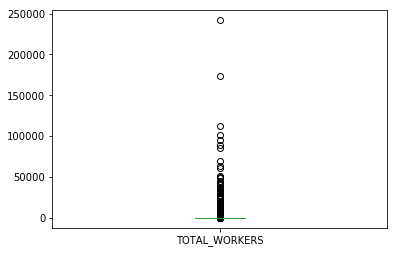

In [89]:
DictyC.plot(kind='box')

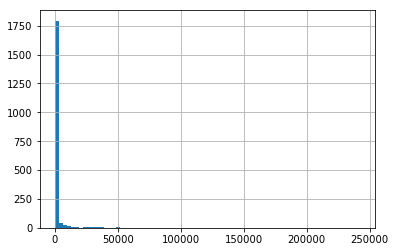

In [91]:
DictyC.hist(bins=75)

In [95]:
DictC.sort_values(by='TOTAL_WORKERS',ascending=False).head(5)

,TOTAL_WORKERS
WORKSITE_COUNTY,
SANTA CLARA,241672
NEW YORK,173362
COOK,112382
KING,100962
MIDDLESEX,95515


So some outliers, especially Santa Clara and New York. Let's remove those two and see how the histogram changes. 

In [97]:
DictyCopy = DictyC.copy()
DictT = DictyCopy.sort_values(ascending=False)[2:]
lower_median_ignore_top = np.percentile(DictT,25)
upper_median_ignore_top = np.percentile(DictT,75)
third_rate = DictyC['COOK']
mean_rate_ignore_top = np.mean(DictT)
median_rate_ignore_top = np.median(DictT)

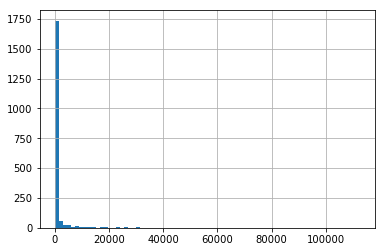

In [98]:
DictT.hist(bins=75)

Hmmm, still fairly close to zero. 

Anyway, let's map these numbers onto the counties using matplotlib Basemap. I played around with this until I got a map that looked nice. I went for a 'traffic lights' system in the end. The counties with ZERO workers were coloured white, and those with 1 got 30% grey. The shading factor went up to 1 at the 25th percentile, which is dark grey. After that starts light green, shading up to bright green at the median. Then starts 30% yellow up to bright yellow at the 75th percentile, and finally red up to bright red at the county in third place, Cook. The first two - Santa Clara and New York - were supposed to have different colours to signify "off the scale", but no colour seemed to work (and New York, or rather Manhattan, is too small to see anyway), so I ended up just colouring them in red. 

Moving Alaska and Hawaii is done before any colouring starts. 

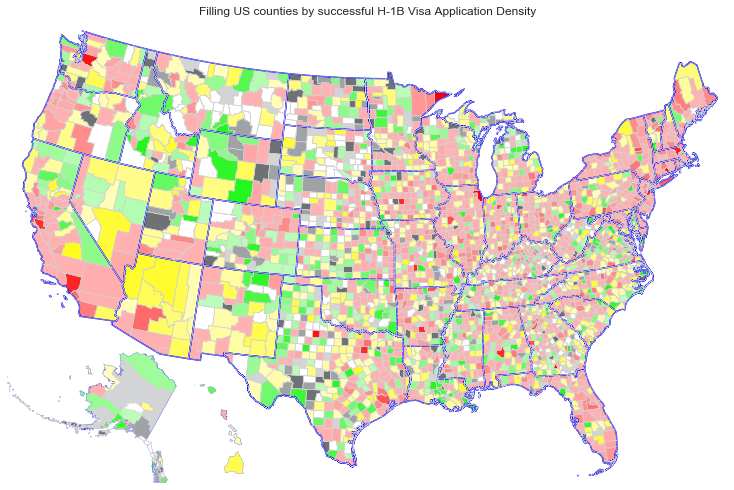

In [197]:
fig, ax = plt.subplots(figsize=(10,20))

from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon

# Lambert Conformal map of lower 48 states.
m = Basemap(resolution='h',llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

#this file has the state boundaries. 



shp_info = m.readshapefile('/Users/barinderbanwait/Downloads/usshapes/cb_2016_us_state_500k', 'states',
                               drawbounds=True, color='blue',linewidth=1.3)

#this file has the county boundaries. Both available from:

#https://www.census.gov/geo/maps-data/data/tiger-cart-boundary.html

shp_info = m.readshapefile('/Users/barinderbanwait/Downloads/usshapes/cb_2016_us_county_500k',
                               'counties',
                               drawbounds=True, color='lightgrey')


ax = plt.gca() # get current axes instance
ax.set_facecolor('none')
statenames = [x['NAME'] for x in m.states_info]

for nshape,seg in enumerate(m.states):  
    if statenames[nshape] == 'Alaska':
        # Alaska is too big. Scale it down to 35% first, then transate it. 
        seg = list(map(lambda xy: (0.35*xy[0] + 950000, 0.35*xy[1]-1350000), seg))
    if statenames[nshape] == 'Hawaii':
        seg = list(map(lambda xy: (xy[0] + 5150000, xy[1]-1400000), seg))

        
    poly = Polygon(seg,facecolor='none',edgecolor="blue")
    ax.add_patch(poly)


KEYS = DictyC.keys()

for x in m.counties_info:
    x["NAME"] = x["NAME"].upper()

county_patches = []
for coordinates, county in zip(m.counties, m.counties_info):
    
    if county["STATEFP"] == '02': #if the county is in Alaska, move it before colouring
        
        coordinates = list(map(lambda xy: (0.35*xy[0] + 950000, 0.35*xy[1]-1350000), coordinates))
    
    elif county["STATEFP"] == '15': #ditto for Hawaii
        coordinates = list(map(lambda xy: (xy[0] + 5150000, xy[1]-1400000), coordinates))
    
    if county["NAME"] == 'SANTA CLARA':
        shade = 1
        poly = Polygon(coordinates,facecolor="#ff2d2d",alpha=shade,edgecolor="lightgrey", lw=.5)
        ax.add_patch(poly)
    elif county["NAME"] == 'NEW YORK':
        shade = 0.5
        poly = Polygon(coordinates,facecolor="#6030ff",alpha=shade,edgecolor="lightgrey", lw=.5)
        ax.add_patch(poly)
    
    elif county["NAME"] in KEYS:
        if DictyC[county["NAME"]] == 0:
            shade = 1
            poly = Polygon(coordinates,facecolor="white",alpha=shade,edgecolor="lightgrey", lw=.5)
            ax.add_patch(poly)
        else:
            if DictyC[county["NAME"]] <= lower_median_ignore_top:
                Inpy = DictyC[county["NAME"]]
                shade = ((0.7*(Inpy - 1))/(lower_median_ignore_top - 1)) + 0.3
                poly = Polygon(coordinates,facecolor="#6e7275",alpha=shade,edgecolor="lightgrey", lw=.5)
                ax.add_patch(poly)
                
            elif DictyC[county["NAME"]] <= median_rate_ignore_top:
                Inpy = DictyC[county["NAME"]]
                shade = ((0.7*(Inpy - median_rate_ignore_top))/(median_rate_ignore_top - lower_median_ignore_top - 1)) + 1
                poly = Polygon(coordinates,facecolor="#24f71d",alpha=shade,edgecolor="lightgrey", lw=.5)
                ax.add_patch(poly)
                
            elif DictyC[county["NAME"]] <= upper_median_ignore_top:
                Inpy = DictyC[county["NAME"]]
                shade = ((0.7*(Inpy - upper_median_ignore_top))/(upper_median_ignore_top - median_rate_ignore_top - 1)) + 1
                poly = Polygon(coordinates,facecolor="#fffb1e",alpha=shade,edgecolor="lightgrey", lw=.5)
                ax.add_patch(poly)
                
            else:
                Inpy = DictyC[county["NAME"]]
                shade = ((0.7*(Inpy - third_rate))/(third_rate - upper_median_ignore_top - 1)) + 1
                poly = Polygon(coordinates,facecolor="red",alpha=shade,edgecolor="lightgrey", lw=.5)
                ax.add_patch(poly)
    
           
    else: #our friend difflib is used to overcome discrepencies between our state names and those in these shapefiles
        Options = difflib.get_close_matches(county["NAME"],KEYS,n=1,cutoff=0.2)
        if len(Options) != 0:
            ProxyCountyName = Options[0]
            if DictyC[ProxyCountyName] == 0:
                shade = 1
                poly = Polygon(coordinates,facecolor="white",alpha=shade,edgecolor="lightgrey", lw=.5)
                ax.add_patch(poly)
            else:
                if DictyC[ProxyCountyName] <= lower_median_ignore_top:
                    Inpy = DictyC[ProxyCountyName]
                    shade = ((0.7*(Inpy - 1))/(lower_median_ignore_top - 1)) + 0.3
                    poly = Polygon(coordinates,facecolor="#6e7275",alpha=shade,edgecolor="lightgrey", lw=.5)
                    ax.add_patch(poly)
                    
                elif DictyC[ProxyCountyName] <= median_rate_ignore_top:
                    Inpy = DictyC[ProxyCountyName]
                    shade = ((0.7*(Inpy - median_rate_ignore_top))/(median_rate_ignore_top - lower_median_ignore_top - 1)) + 1
                    poly = Polygon(coordinates,facecolor="#24f71d",alpha=shade,edgecolor="lightgrey", lw=.5)
                    ax.add_patch(poly)
                    
                elif DictyC[ProxyCountyName] <= upper_median_ignore_top:
                    Inpy = DictyC[ProxyCountyName]
                    shade = ((0.7*(Inpy - upper_median_ignore_top))/(upper_median_ignore_top - median_rate_ignore_top - 1)) + 1
                    poly = Polygon(coordinates,facecolor="#fffb1e",alpha=shade,edgecolor="lightgrey", lw=.5)
                    ax.add_patch(poly)
                    
                else:
                    Inpy = DictyC[ProxyCountyName]
                    shade = ((0.7*(Inpy - third_rate))/(third_rate - upper_median_ignore_top - 1)) + 1
                    poly = Polygon(coordinates,facecolor="red",alpha=shade,edgecolor="lightgrey", lw=.5)
                    ax.add_patch(poly)
                   
    
        else:
            shade = 1
    
            poly = Polygon(coordinates,facecolor="white",alpha=shade,edgecolor="lightgrey", lw=.5)
            ax.add_patch(poly)

plt.title('Filling US counties by successful H-1B Visa Application Density')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.show()

<font size="4"><center><big><b>Predicting Salaries </font></center></big></b>

We take the columns we think will be relevant to predicting salary. 

In [109]:
DesiredCols = ['CASE_STATUS','SOC_CODE','PREVAILING_WAGE','PW_UNIT_OF_PAY','WAGE_RATE_OF_PAY_FROM','WAGE_UNIT_OF_PAY','WORKSITE_STATE']
df14c2 = df14.copy()
df15c2 = df15.copy()
df16c2 = df16.copy()
df14c2,df15c2,df16c2 = [dat[DesiredCols] for dat in [df14c2,df15c2,df16c2]]
df14c2,df15c2,df16c2 = [dat.drop_duplicates() for dat in [df14c2,df15c2,df16c2]]

The game we're going to play will be to use the 2014 and 2015 data to train an algorithm, and test it against the 2016 data. So the 2014 and 15 data will be the train, and the 2016 the test. But when cleaning them, it's easier to concatenate them. (We didn't do that earlier because there were too many differences between them, but now they've been cleaned and standardised). Since we'll have ot split them again later, we introduce the column 'IsTrain'.

We also only take data that is a yearly salary or an hourly wage, ignoring the monthly, weekly etc salaries. 

In [118]:
df1 = pd.concat([df14c2,df15c2],ignore_index=True)
df1 = df1.drop_duplicates()
df1 = df1[(df1['WAGE_UNIT_OF_PAY'] == 'Year') | (df1['WAGE_UNIT_OF_PAY'] == 'Hour')]
df1 = df1.reset_index(drop=True)
df1['IsTrain'] = 1

df16c2 = df16c2.drop_duplicates()
df16c2 = df16c2[(df16c2['WAGE_UNIT_OF_PAY'] == 'Year') | (df16c2['WAGE_UNIT_OF_PAY'] == 'Hour')]
df16c2 = df16c2.reset_index(drop=True)
df16c2['IsTrain'] = 0

df = pd.concat([df1,df16c2],ignore_index=True)


Now we need to be careful about the values in the wages columns! There is a grey area between extremely high hourly wages and extremely low yearly salaries. We take a look at this grey area in our data:

In [119]:
df.loc[(df['WAGE_RATE_OF_PAY_FROM'] > 800) & (df['WAGE_RATE_OF_PAY_FROM'] < 15000)].sort_values('WAGE_RATE_OF_PAY_FROM',ascending=False)
#df.loc[(df['PW_UNIT_OF_PAY'] == 'Hour') & (df['PREVAILING_WAGE'] > 80000)].sort_values('WAGE_RATE_OF_PAY_FROM',ascending=False)


,CASE_STATUS,SOC_CODE,PREVAILING_WAGE,PW_UNIT_OF_PAY,WAGE_RATE_OF_PAY_FROM,WAGE_UNIT_OF_PAY,WORKSITE_STATE,IsTrain
188190,DENIED,25-1071,40430.00,Year,10500.0,Year,LA,1
188530,DENIED,25-1071,40430.00,Year,10000.0,Year,LA,1
132578,WITHDRAWN,17-3022,56368.00,Year,7000.0,Year,MD,1
141629,DENIED,17-3022,60258.00,Year,7000.0,Year,MD,1
7812,CERTIFIED-WITHDRAWN,15-1132,62358.00,Year,6300.0,Hour,MO,1
39224,WITHDRAWN,29-1051,46.76,Hour,6200.0,Hour,VA,1
668581,DENIED,17-2051,38.00,Hour,3800.0,Hour,NJ,0
649544,DENIED,15-1199,9.00,Hour,3600.0,Year,MS,0
123337,WITHDRAWN,17-2072,29.38,Hour,2938.0,Hour,GA,1
417032,DENIED,41-3011,2000.00,Year,2000.0,Year,CA,1


We see here some clear nonsense. I mean, who gets paid $6,300 an hour?!? Or only 7,000 a year when the average is 60k? Of course, these should probably be multipled by 10 (and it's a yearly salary in the former case). 

In [120]:
df.loc[(df['WAGE_RATE_OF_PAY_FROM'] < 800) & (df['WAGE_UNIT_OF_PAY'] == 'Year')].sort_values('WAGE_RATE_OF_PAY_FROM',ascending=False)

,CASE_STATUS,SOC_CODE,PREVAILING_WAGE,PW_UNIT_OF_PAY,WAGE_RATE_OF_PAY_FROM,WAGE_UNIT_OF_PAY,WORKSITE_STATE,IsTrain
724234,DENIED,27-1011,35.00,Year,35.00,Year,FL,0
669506,DENIED,17-2051,15.44,Hour,15.44,Year,MP,0
743660,DENIED,41-9022,0.00,Year,1.00,Year,FL,0
399995,DENIED,21-2099,0.00,Year,0.00,Year,AZ,1
566661,WITHDRAWN,15-1131,0.00,Year,0.00,Year,NJ,0
743112,DENIED,39-9099,15000.00,Year,0.00,Year,FL,0


More nonsense...who get's $1 a year? 

It's not surprising that these applications were Denied...actually this led me to investigate the later project of predicting outcome based on how many "nonsense values" there were, with some clear outcomes...but more on that later. 

In [122]:
df.loc[(df['WAGE_RATE_OF_PAY_FROM'] > 8000) & (df['WAGE_UNIT_OF_PAY'] == 'Hour')].sort_values('WAGE_RATE_OF_PAY_FROM',ascending=False).head(5)


,CASE_STATUS,SOC_CODE,PREVAILING_WAGE,PW_UNIT_OF_PAY,WAGE_RATE_OF_PAY_FROM,WAGE_UNIT_OF_PAY,WORKSITE_STATE,IsTrain
48426,CERTIFIED,13-2011,76149.00,Year,10186389.00,Hour,IL,1
130666,WITHDRAWN,29-1051,43.52,Hour,437840.52,Hour,CA,1
143153,WITHDRAWN,17-3026,35400.00,Year,328885.00,Hour,AL,1
422609,WITHDRAWN,29-1069,113589.00,Year,250000.00,Hour,CA,1
737130,WITHDRAWN,29-1069,187200.00,Year,230971.00,Hour,NY,0


We decide based on these tables that any number in either of the Wages columns that is less than 800 must be an hourly wage, any number that is bigger than 5000 must be a yearly salary, and any number in between probably needs to be multiplied by 10 to become a proper yearly salary. Also, we decided that any number in these columns that is less than 5 is probably an error, and will be replaced as NaN, which we'll deal with subsequently.

In [123]:
def SortOutWages(x):
    if x < 5:
        return np.nan
    if x > 800 and x < 8000:
        return 10*x
    else:
        return x
    
def SortOutUnit(x):
    if x <=800:
        return 'Hour'
    else:
        return 'Year'

def CleanSoc(x): #just another sanity on SOC_CODE, not really necessary...
    if x.isnumeric():
        return x
    else:
        return '0'    

#fixing some ad-hoc values that we saw above...
    
df = df.set_value(123337,'WAGE_RATE_OF_PAY_FROM',29.38)
df = df.set_value(668581,'WAGE_RATE_OF_PAY_FROM',38)
df = df.set_value(7812,'WAGE_RATE_OF_PAY_FROM',63000)

In [124]:
df['WAGE_RATE_OF_PAY_FROM'] = df['WAGE_RATE_OF_PAY_FROM'].apply(SortOutWages)
df['WAGE_UNIT_OF_PAY'] = df['WAGE_RATE_OF_PAY_FROM'].apply(SortOutUnit)
df['PREVAILING_WAGE'] = df['PREVAILING_WAGE'].apply(SortOutWages)
df['PW_UNIT_OF_PAY'] = df['PREVAILING_WAGE'].apply(SortOutUnit)

Having made the wages more reasonable, let's now try to fill in the NaNs in the Prevailing wage. There are only 9 nans in the Wage column, which we'll just drop. 

In [125]:
df.isnull().sum()

CASE_STATUS                0
SOC_CODE                  42
PREVAILING_WAGE          111
PW_UNIT_OF_PAY             0
WAGE_RATE_OF_PAY_FROM      9
WAGE_UNIT_OF_PAY           0
WORKSITE_STATE            28
IsTrain                    0
dtype: int64

Actually, we'll only take the first two digits of the SOC-CODE as a proxy for the kind of work the applicant will be doing; this could be a good predictor. 

In [129]:
#Fill NaNs in SOC_CODE with 00-0000.

df.SOC_CODE.fillna('00-0000',inplace=True)
df['SOC_CODE']= df['SOC_CODE'].apply(lambda x:x[:2]) #take only first two digits
df['SOC_CODE'] = df['SOC_CODE'].apply(CleanSoc)
df.SOC_CODE = df.SOC_CODE.astype(int)
df = df.reset_index(drop=True)

Let's see the difference between prevailing wage and actual wage for a yearly salary.

In [132]:
trainc = df.copy()
    
trainc = trainc[(trainc['WAGE_UNIT_OF_PAY'] == 'Year') & (trainc['PW_UNIT_OF_PAY'] == 'Year')]
trainc = trainc.dropna(subset=['PREVAILING_WAGE','WAGE_RATE_OF_PAY_FROM'])
trainc.PREVAILING_WAGE = trainc.PREVAILING_WAGE.astype(float)
trainc.WAGE_RATE_OF_PAY_FROM = trainc.WAGE_RATE_OF_PAY_FROM.astype(float)
trainc['DIFFERENCE'] = trainc['WAGE_RATE_OF_PAY_FROM'] - trainc['PREVAILING_WAGE']
trainc.dropna(inplace=True)
trainc = trainc.reset_index(drop=True)

Let's see how that difference looks for the difference (truncated) SOC-CODES:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x19d835b38>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x18c3c6ef0>]], dtype=object)

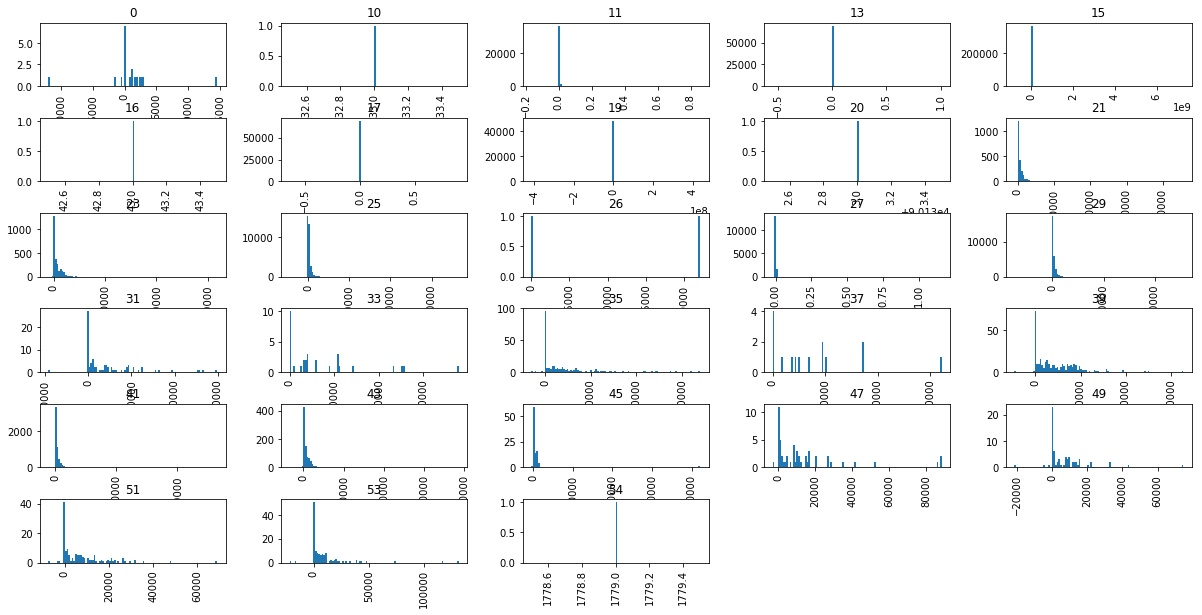

In [133]:
trainc['DIFFERENCE'].hist(by=trainc['SOC_CODE'], bins=100,figsize=(20,10))

More closely...

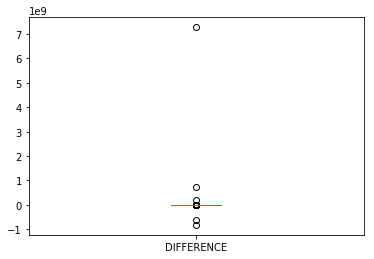

In [134]:
trainc[trainc['SOC_CODE'] == 15]['DIFFERENCE'].plot(kind='box')

Based on this foray, it's clear that there's not much difference between the prevailing wage and actual wage. However, we're going to fill the NaNs in the prevailing wage as follows:

Compute the median (yearly) wage difference between PW and WAGE for each SOC code, and fill in the PREVAILING_WAGE by subtracting this median wage difference from the Wage column. For hourly wages, just take the value in the wage column. 

In [135]:
MedianWageDifference = trainc.groupby('SOC_CODE').median()['DIFFERENCE'].to_dict()
MedianWage = trainc.groupby('SOC_CODE').median()['WAGE_RATE_OF_PAY_FROM'].to_dict()

In [136]:
for i,x in enumerate(df.PREVAILING_WAGE):
    if pd.isnull(x):
        if not pd.isnull(df.loc[i,'WAGE_RATE_OF_PAY_FROM']):
            if df.loc[i,'WAGE_UNIT_OF_PAY'] == 'Hour':
                y = df.loc[i,'WAGE_RATE_OF_PAY_FROM']
                df.set_value(i,'PREVAILING_WAGE', y) #if hourly wage, just take the wage
            else:
                try:
                    df.loc[i,'PREVAILING_WAGE'] = df.loc[i,'WAGE_RATE_OF_PAY_FROM'] - MedianWageDifference[df.loc[i,'SOC_CODE']]
                except KeyError: #the SOC-CODE might not have made it to the truncated MedianWageDifference
                    df.loc[i,'PREVAILING_WAGE'] = df.loc[i,'WAGE_RATE_OF_PAY_FROM']
        else:
            try:
                df.loc[i,'PREVAILING_WAGE'] = MedianWage[df.loc[i,'SOC_CODE']]
                df.loc[i,'WAGE_RATE_OF_PAY_FROM'] = MedianWage[df.loc[i,'SOC_CODE']]
            except KeyError: #SOC-CODE might be NaN
                pass
             
df = df.dropna(subset=['PREVAILING_WAGE','WAGE_RATE_OF_PAY_FROM'])
df = df.reset_index(drop=True)

#Having played with the wages columns, we'll apply our rule from earlier to bring the wages
#back into line. 

df['WAGE_RATE_OF_PAY_FROM'] = df['WAGE_RATE_OF_PAY_FROM'].apply(SortOutWages)
df['WAGE_UNIT_OF_PAY'] = df['WAGE_RATE_OF_PAY_FROM'].apply(SortOutUnit)
df['PREVAILING_WAGE'] = df['PREVAILING_WAGE'].apply(SortOutWages)
df['PW_UNIT_OF_PAY'] = df['PREVAILING_WAGE'].apply(SortOutUnit)
       
df['WORKSITE_STATE'] = df['WORKSITE_STATE'].fillna('CA') #the mode

The algorithms will need numerical values, so we map the categorical values with dictionaries. We rank the states according to median wage for applications in that state (1 is high), similarly rank the SOC-CODES according to median wage of that SOC CODE. 

In [137]:
#Rank the states and SOC_CODES according to the money:

StateDict = df.groupby(['WORKSITE_STATE']).median()['WAGE_RATE_OF_PAY_FROM'].rank(method='first',numeric_only=True,ascending=False).sort_values().to_dict()
SocCodeDict = df.groupby(['SOC_CODE']).median()['WAGE_RATE_OF_PAY_FROM'].rank(method='first',numeric_only=True,ascending=False).sort_values().to_dict()


StatusDict = {'CERTIFIED' : 1,
              'CERTIFIED-WITHDRAWN' : 2,
              'WITHDRAWN' : 3,
              'DENIED' : 4 }

#Apply the mapping, tie up loose ends:

df['STATE_CODE'] = df['WORKSITE_STATE'].map(StateDict)
df['PW_IsYearly'] = df['PW_UNIT_OF_PAY'].apply(lambda x : 1 if x == 'Year' else 0)
df['WAGE_IsYearly'] = df['WAGE_UNIT_OF_PAY'].apply(lambda x : 1 if x == 'Year' else 0)
df['SOC_CODE'] = df['SOC_CODE'].map(SocCodeDict)
df['CASE_STATUS'] = df['CASE_STATUS'].map(StatusDict)
df = df.drop(['WORKSITE_STATE','PW_UNIT_OF_PAY','WAGE_UNIT_OF_PAY'],axis=1)
df.dropna(inplace=True)
df = df.reset_index(drop=True)
df['STATE_CODE'] = df['STATE_CODE'].astype(int)
df['SOC_CODE'] = df['SOC_CODE'].astype(int)
df['CASE_STATUS'] = df['CASE_STATUS'].astype(int)

In [138]:
df.head(3)

,CASE_STATUS,SOC_CODE,PREVAILING_WAGE,WAGE_RATE_OF_PAY_FROM,IsTrain,STATE_CODE,PW_IsYearly,WAGE_IsYearly
0,2,13,43118.0,50000.0,1,7,1,1
1,1,8,64251.0,65000.0,1,38,1,1
2,4,11,50000.0,50000.0,1,29,1,1


We'll now split the train and test data, and see a correlation map of our variables. 

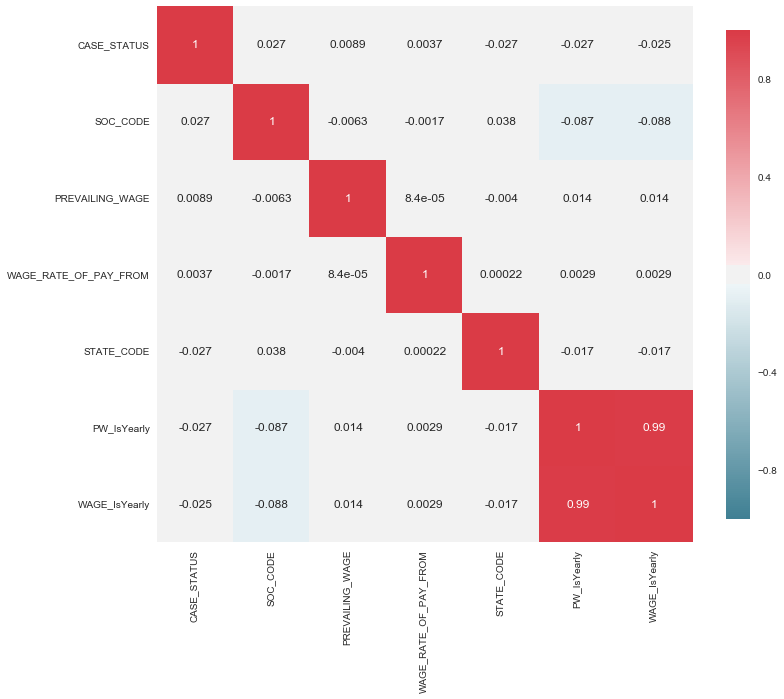

In [140]:
train = df[df['IsTrain'] == 1]
train = train.drop(['IsTrain'],axis=1)

test = df[df['IsTrain'] == 0]
test = test.drop(['IsTrain'],axis=1)

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )


plot_correlation_map( train )

Just out of curiosity, here's how "computer" jobs (SOC_CODE 5) are distributed across the states. We see that California (state 2) has quite a chunk of them.  

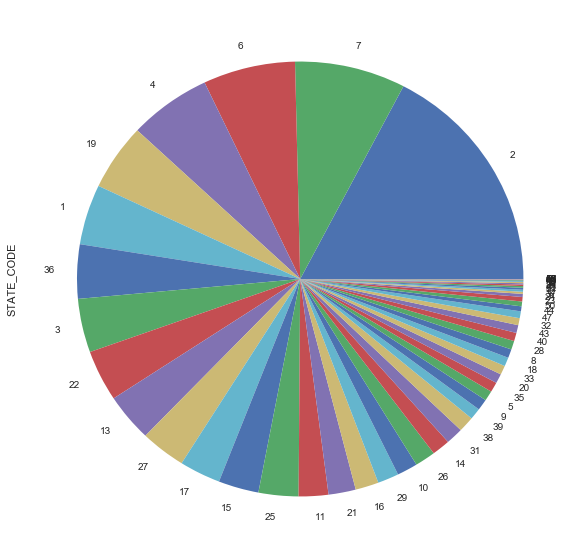

In [202]:
train[train['SOC_CODE'] == 5].STATE_CODE.value_counts().plot(kind='pie',figsize=(10,10))

Also, how are the Prevailing wage and actual wage correlated? Let's see a scatter chart:

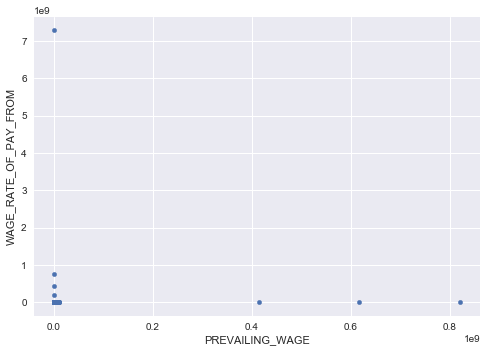

In [145]:
df[(df['PW_IsYearly'] == 1) & (df['WAGE_IsYearly'] == 1)].plot(x='PREVAILING_WAGE',y='WAGE_RATE_OF_PAY_FROM',kind='scatter')

Well that's not very useful...let's remove those outliers first.

In [146]:
filt_df = df[(df['PW_IsYearly'] == 1) & (df['WAGE_IsYearly'] == 1)][['PREVAILING_WAGE','WAGE_RATE_OF_PAY_FROM']]
low = 0.05
high = 0.95
quant_df = filt_df.quantile([low, high]) #ignore top and bottom 5th percentiles
filt_df = filt_df.apply(lambda x: x[(x > quant_df.loc[low,x.name]) & 
                                    (x < quant_df.loc[high,x.name])], axis=0)

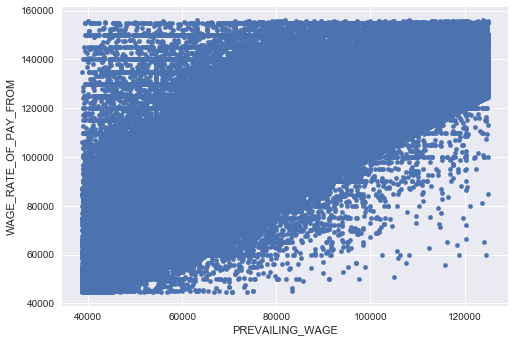

In [147]:
filt_df.plot(x='PREVAILING_WAGE',y='WAGE_RATE_OF_PAY_FROM',kind='scatter')

Hmmm...hard to make heads or tails of that. It does show that very few people get offered a wage *less* than the prevailing wage though.

OK, enough graphs. On with the training of a machine learning algorithm. I'll just keep this simple and use a 100-deep Random Forest. 

In [150]:
X_train = train.drop('WAGE_RATE_OF_PAY_FROM', axis=1).copy()
Y_train = train['WAGE_RATE_OF_PAY_FROM'].copy()
X_test  = test.drop('WAGE_RATE_OF_PAY_FROM', axis=1).copy()
Y_test = test['WAGE_RATE_OF_PAY_FROM'].copy()

In [152]:
random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

42.170000000000002

Hmmm, that's not a great score...let's see which features were used in the training.

In [159]:
rf_features = random_forest.feature_importances_.tolist()

In [168]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

cols = X_train.columns.values

feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
    })

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
      
       
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',

#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

Not surprisingly the prevailing wage was by far the most important predictor. How did we score on Root Mean Squared Error?

In [163]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(Y_test,Y_pred))

317938.18734440405

<font size="4"><center><big><b>Predicting application success </font></center></big></b>

In a similar vein to predicting salaries, can we predict application success? We'll remove
'CERTIFIED-WITHDRAWN' entries since they pertain to already certified application, and we'll consider WITHDRAWN and DENIED on a similar footing. 

However, as mentioned above, an important predictor here could be the number of NaNs in an application row. So we should take care *not* to fill those in, at least until we've had a chance to coun them. 

By NaNs I really mean "nonsense values", so entries in the wages column of a million dollars an hour will count as a NaN, for example. 

In [170]:
df14c,df15c,df16c = [dat[DesiredCols] for dat in [df14,df15,df16]]

Df1 = pd.concat([df14c,df15c],ignore_index=True)
Df1 = Df1.drop_duplicates()
Df1 = Df1[(Df1['WAGE_UNIT_OF_PAY'] == 'Year') | (Df1['WAGE_UNIT_OF_PAY'] == 'Hour')]
Df1 = Df1.reset_index(drop=True)
Df1['IsTrain'] = 1

df16c = df16c.drop_duplicates()
df16c = df16c[(df16c['WAGE_UNIT_OF_PAY'] == 'Year') | (df16c['WAGE_UNIT_OF_PAY'] == 'Hour')]
df16c = df16c.reset_index(drop=True)
df16c['IsTrain'] = 0

Df = pd.concat([Df1,df16c],ignore_index=True)
Df = Df[Df['CASE_STATUS'] != 'CERTIFIED-WITHDRAWN']
Df = Df.reset_index(drop=True)

NewStatusDict = {'CERTIFIED' : 1,
              'WITHDRAWN' : 0,
              'DENIED' : 0 }

Df['STATE_CODE'] = Df['WORKSITE_STATE'].map(StateDict,na_action='ignore')
Df['SOC_CODE'] = Df['SOC_CODE'].fillna('na')
Df['SOC_CODE'] = Df['SOC_CODE'].apply(lambda x : SocCodeDict[int(x[:2])] if x[:2].isnumeric() else np.nan)
Df['CASE_STATUS'] = Df['CASE_STATUS'].map(NewStatusDict, na_action='ignore')
Df = Df.reset_index(drop=True)
Df = Df.drop('WORKSITE_STATE',axis=1)

Here we detect nonsense in the wages columns. We already identified the nonsense above: hourly wages above 800 dollars, yearly wages below 8000 dollars, any amount below 5 dollars, as well as any existing NaNs. Also important might be if the PREVAILING_WAGE accords with the actual wage; they might make sense amongst themselves, but if one of them is given as a yearly salary, and the other an hourly wage, that might be a red flag. 

We also add a column counting the NaNs after applying the nonsense detection. 

In [171]:
def NonsensePW(row):
    if pd.isnull(row['PREVAILING_WAGE']):
        return np.nan
    elif pd.isnull(row['PW_UNIT_OF_PAY']):
        return np.nan
    elif row['PREVAILING_WAGE'] < 5:
        return np.nan
    else:
        if row['PW_UNIT_OF_PAY'] == 'Year' and row['PREVAILING_WAGE'] < 8000:
            return np.nan
        if row['PW_UNIT_OF_PAY'] == 'Hour' and row['PREVAILING_WAGE'] > 800:
            return np.nan
        else:
            return row['PREVAILING_WAGE']

def NonsenseWAGE(row):
    if pd.isnull(row['WAGE_RATE_OF_PAY_FROM']):
        return np.nan
    elif pd.isnull(row['WAGE_UNIT_OF_PAY']):
        return np.nan
    elif row['WAGE_RATE_OF_PAY_FROM'] < 5:
        return np.nan
    else:
        if row['WAGE_UNIT_OF_PAY'] == 'Year' and row['WAGE_RATE_OF_PAY_FROM'] < 8000:
            return np.nan
        if row['WAGE_UNIT_OF_PAY'] == 'Hour' and row['WAGE_RATE_OF_PAY_FROM'] > 800:
            return np.nan
        else:
            return row['WAGE_RATE_OF_PAY_FROM']
    
def WageSense(row):
    if row['PW_UNIT_OF_PAY'] == 'Year' and row['WAGE_UNIT_OF_PAY'] == 'Year':
        return 1
    if row['PW_UNIT_OF_PAY'] == 'Hour' and row['WAGE_UNIT_OF_PAY'] == 'Hour':
        return 1
    else:
        return 0
        
Df['PREVAILING_WAGE'] = Df.apply(NonsensePW,axis=1)
Df['PW_UNIT_OF_PAY'] = Df.apply(lambda row: np.nan if pd.isnull(row['PREVAILING_WAGE']) else row['PW_UNIT_OF_PAY'],axis=1)
Df['WAGE_RATE_OF_PAY_FROM'] = Df.apply(NonsenseWAGE,axis=1)
Df['WAGE_UNIT_OF_PAY'] = Df.apply(lambda row: np.nan if pd.isnull(row['WAGE_RATE_OF_PAY_FROM']) else row['WAGE_UNIT_OF_PAY'],axis=1)

Df['WagesMakeSense'] = Df.apply(WageSense,axis=1)

Df['NaNs'] = Df.isnull().sum(axis=1) #count the nans
Df = Df.drop(['PREVAILING_WAGE','PW_UNIT_OF_PAY','WAGE_RATE_OF_PAY_FROM','WAGE_UNIT_OF_PAY'],axis=1)

Df['SOC_CODE'] = Df['SOC_CODE'].fillna(5) #the mode
Df['STATE_CODE'] = Df['STATE_CODE'].fillna(2) #the mode, CA

In [172]:
Df['CASE_STATUS'] = Df['CASE_STATUS'].astype(int)
Df['SOC_CODE'] = Df['SOC_CODE'].astype(int)
Df['STATE_CODE'] = Df['STATE_CODE'].astype(int)

Here is some evidence that the NaNs column may be significant for us. First let's see the outcome of applications that had a NaN in them.

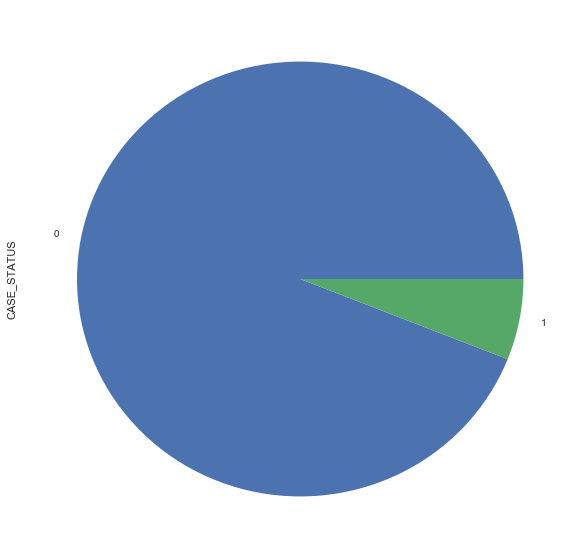

In [173]:
Df[Df['NaNs'] > 0]['CASE_STATUS'].value_counts().plot(kind='pie',figsize=(10,10))

The vast majority of them were rejected. 

Now let's see the analogous pie chart for those applications that had no NaNs:

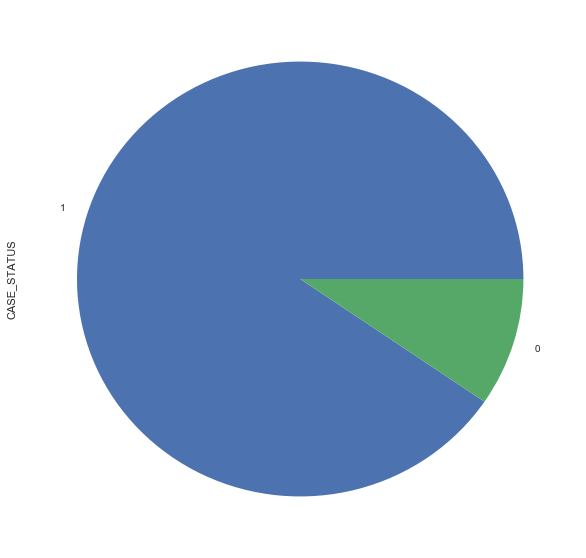

In [174]:
Df[Df['NaNs'] == 0]['CASE_STATUS'].value_counts().plot(kind='pie',figsize=(10,10))

The picture is reversed! Most of them were certified. It seems that it's worth making sure your visa application has absolutely no errors in it.  

So finally we run a Random Forest algorithm. 

In [175]:
train = Df[Df['IsTrain'] == 1]
train = train.drop(['IsTrain'],axis=1)

test = Df[Df['IsTrain'] == 0]
test = test.drop(['IsTrain'],axis=1)

X_train = train.drop('CASE_STATUS', axis=1).copy()
Y_train = train['CASE_STATUS'].copy()
X_test  = test.drop('CASE_STATUS', axis=1).copy()
Y_test = test['CASE_STATUS'].copy()

from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

90.359999999999999

Not a bad score...how are things correlated?

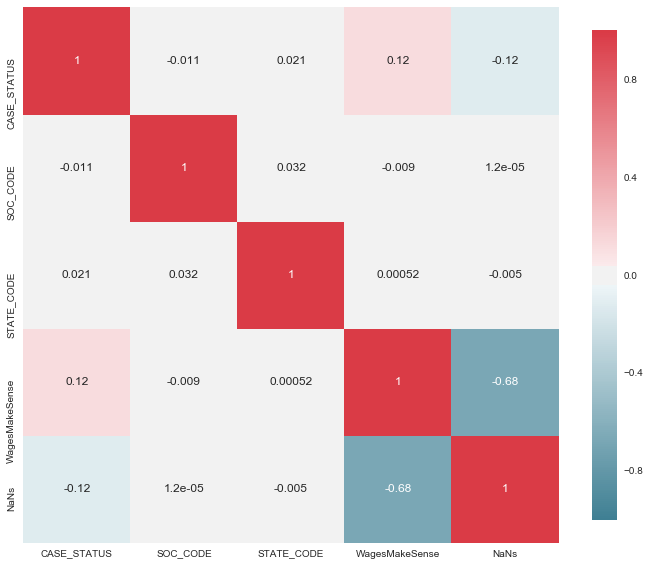

In [178]:
plot_correlation_map(train)

So indeed, WagesMakesSense and NaNs seem particularly relevant.

In [176]:
rf_features = random_forest.feature_importances_.tolist()

In [177]:
cols = X_train.columns.values

feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
    })

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       
        
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',

    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

Our score wasn't so bad:

In [180]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,Y_pred)

0.90723012013487636

But wait...how many applications were rejected out of those accepted, from our training data?

In [181]:
train['CASE_STATUS'].value_counts()[0]/train['CASE_STATUS'].value_counts()[1]

0.10944398374550819

Is our fancy Random Forest predictor better than the naive method of flipping a biased 10:1 coin to predict the outcome of an application? (aka Bernoulli 1/11 distribution)

In [182]:
Y_pred_Coin = []
for i in range(len(Y_test)):
    x = np.random.randint(low=1,high=12)
    if x == 1:
        Y_pred_Coin.append(0)
    else:
        Y_pred_Coin.append(1)

In [183]:
accuracy_score(Y_test,Y_pred_Coin)

0.83215005845773249

So yes, our fancy Random Forest is rather more accurate than just randomly choosing 1/11 of applications to be rejected. 